In [4]:
import torch
from torch.utils.data import DataLoader
from step3_dataset import CervicalDataset, get_transforms
import segmentation_models_pytorch as smp
import os
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
from scipy.ndimage import zoom
import seaborn as sns
from sklearn.metrics import confusion_matrix


# 우리가 만든 데이터셋 모듈 불러오기 (파일명이 step3_dataset.py 인지 확인!)
from step3_dataset import CervicalDataset, get_transforms
import segmentation_models_pytorch as smp

In [5]:
# 0. 경로 및 하이퍼파라미터 설정
GOLD_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
DATA_DIR = os.path.join(GOLD_DIR, 'segmentation_preprocessed') 

TRAIN_TXT = os.path.join(GOLD_DIR, 'fold1_train.txt')
VAL_TXT = os.path.join(GOLD_DIR, 'fold1_val.txt')


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SAVE_DIR = './checkpoints'
os.makedirs(SAVE_DIR, exist_ok=True)
MODEL_PATH = './checkpoints/best_model_fold1.pth'

In [6]:
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 50

## 데이터 불러오기

In [4]:
# 1. 데이터셋 및 로더 생성
# 학습용
train_ds = CervicalDataset(
    patient_list_file=TRAIN_TXT, 
    data_dir=DATA_DIR, 
    transform=get_transforms('train')
)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# 검증용
val_ds = CervicalDataset(
    patient_list_file=VAL_TXT, 
    data_dir=DATA_DIR, 
    transform=get_transforms('val')
)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 2. 테스트 확인 (제대로 나오는지 딱 한 번만 출력)
print(f"🚀 학습 장치: {DEVICE}")
for imgs, masks in train_loader:
    print(f"✅ 이미지 배치 형태: {imgs.shape}") # [32, 2, 224, 224] (2채널 확인!)
    print(f"✅ 마스크 배치 형태: {masks.shape}") # [32, 224, 224]

    # ⭐ 여기가 핵심: 0~7까지만 있어야 함
    unique_vals = torch.unique(masks)
    print(f"현재 배치에 포함된 라벨들: {unique_vals.tolist()}")
    
    if max(unique_vals) > 7:
        print("🚨 비상! 아직도 8 이상의 숫자가 들어있습니다. Dataset 코드를 다시 보세요!")
    else:
        print("✅ 클린합니다. 이제 모델을 생성해도 좋습니다.")
    break

c:\Users\smc\anaconda3\envs\torch_cu13\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


🧠 C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\fold1_train.txt 데이터를 RAM에 로딩 중...


100%|██████████| 69/69 [00:02<00:00, 31.07it/s]


✅ 로딩 완료!
🧠 C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\fold1_val.txt 데이터를 RAM에 로딩 중...


100%|██████████| 18/18 [00:00<00:00, 32.34it/s]


✅ 로딩 완료!
🚀 학습 장치: cuda
✅ 이미지 배치 형태: torch.Size([32, 2, 224, 224])
✅ 마스크 배치 형태: torch.Size([32, 224, 224])
현재 배치에 포함된 라벨들: [0, 1, 2, 3, 4, 5, 6, 7]
✅ 클린합니다. 이제 모델을 생성해도 좋습니다.


## 모델 정의

In [7]:
# --- [모델 정의 (2채널 입력)] ---
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=2,  # 이미지(1) + Z-position(1)
    classes=8       # 배경 + C1~C7
).to(DEVICE)

## loss function

In [6]:
# --- [손실함수 및 최적화 도구] ---
# DiceLoss와 CrossEntropy를 합쳐서 사용합니다.
criterion_dice = smp.losses.DiceLoss(mode='multiclass')
criterion_ce = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

## dice score

In [7]:
def get_detailed_dice(outputs, masks, num_classes=8):
    # 가장 높은 확률을 가진 클래스로 예측 [B, H, W]
    preds = torch.argmax(outputs, dim=1)
    dice_list = []
    
    for cl in range(1, num_classes): # 1(C1)부터 7(C7)까지
        pred_cl = (preds == cl).float()
        true_cl = (masks == cl).float()
        
        intersection = (pred_cl * true_cl).sum()
        union = pred_cl.sum() + true_cl.sum()
        
        # 분모가 0인 경우를 대비해 smooth(1e-6) 추가
        dice = (2. * intersection + 1e-6) / (union + 1e-6)
        dice_list.append(dice.item())
        
    return dice_list # [C1_dice, C2_dice, ..., C7_dice]

## train / val

In [8]:
# --- [학습 루프 정의] ---
best_val_loss = float('inf')
patience = 50  # 성능 개선이 50번 연속 없으면 종료
counter = 0    # 개선 없는 횟수를 세는 카운터

# [0] 학습 기록을 담을 리스트 초기화
history = {
    'epoch': [],
    'train_loss': [], 'val_loss': [],
    'train_dice_mean': [], 'val_dice_mean': []
}
# C1~C7 개별 기록을 위한 키 추가
for i in range(1, 8):
    history[f'train_dice_C{i}'] = []
    history[f'val_dice_C{i}'] = []

history_path = os.path.join(SAVE_DIR, 'train_history_fold1.csv')

In [9]:
for epoch in range(EPOCHS):
    # --- [1] Train Phase ---
    model.train()
    train_loss = 0
    train_dice_accum = np.zeros(7) # C1~C7 점수 누적용
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    for imgs, masks in pbar:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE).long()
        optimizer.zero_grad()
        
        outputs = model(imgs)
        loss = 0.5 * criterion_dice(outputs, masks) + 0.5 * criterion_ce(outputs, masks)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # Dice 계산 및 누적
        batch_dice_list = get_detailed_dice(outputs, masks)
        train_dice_accum += np.array(batch_dice_list)
        
        # pbar 출력 (평균 Dice로 표시)
        pbar.set_postfix(loss=f"{loss.item():.4f}", dice=f"{np.mean(batch_dice_list):.4f}")

    avg_train_loss = train_loss / len(train_loader)
    avg_train_dice_list = train_dice_accum / len(train_loader)
    avg_train_dice_mean = np.mean(avg_train_dice_list)

    # --- [2] Validation Phase ---
    model.eval()
    val_loss = 0
    val_dice_accum = np.zeros(7)
    
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE).long()
            outputs = model(imgs)
            
            loss = 0.5 * criterion_dice(outputs, masks) + 0.5 * criterion_ce(outputs, masks)
            val_loss += loss.item()
            
            # Dice 계산 및 누적
            batch_dice_list = get_detailed_dice(outputs, masks)
            val_dice_accum += np.array(batch_dice_list)

    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice_list = val_dice_accum / len(val_loader)
    avg_val_dice_mean = np.mean(avg_val_dice_list)
    
    print(f"▶ Epoch {epoch+1} 완료 | Loss: (T){avg_train_loss:.4f} (V){avg_val_loss:.4f} | Dice: (T){avg_train_dice_mean:.4f} (V){avg_val_dice_mean:.4f}")

    # --- [3] 모델 저장 및 EarlyStopping ---
    scheduler.step(avg_val_loss)
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), os.path.join(SAVE_DIR, 'best_model_fold1.pth'))
        print(f"⭐ Best Model 갱신 및 저장 완료!")
        counter = 0
    else:
        counter += 1
        print(f"⚠️ 개선 없음 (카운터: {counter}/{patience})")

    # --- [4] 기록 추가 및 저장 ---
    history['epoch'].append(epoch + 1)
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_dice_mean'].append(avg_train_dice_mean)
    history['val_dice_mean'].append(avg_val_dice_mean)
    
    # C1~C7 개별 점수 기록
    for i in range(1, 8):
        history[f'train_dice_C{i}'].append(avg_train_dice_list[i-1])
        history[f'val_dice_C{i}'].append(avg_val_dice_list[i-1])

    pd.DataFrame(history).to_csv(history_path, index=False)
    print(f"📊 학습 기록 저장 완료: {history_path}")
        
    if counter >= patience:
        print(f"🛑 조기 종료")
        break

print("🎊 모든 학습 과정이 종료되었습니다!")

Epoch 1/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.57it/s, dice=0.2303, loss=0.5668]


▶ Epoch 1 완료 | Loss: (T)0.8857 (V)0.3265 | Dice: (T)0.1075 (V)0.2301
⭐ Best Model 갱신 및 저장 완료!
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 2/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.57it/s, dice=0.4076, loss=0.4039]


▶ Epoch 2 완료 | Loss: (T)0.4792 (V)0.1772 | Dice: (T)0.3005 (V)0.4471
⭐ Best Model 갱신 및 저장 완료!
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 3/50 [Train]: 100%|██████████| 276/276 [00:48<00:00,  5.65it/s, dice=0.6490, loss=0.2519]


▶ Epoch 3 완료 | Loss: (T)0.3163 (V)0.1191 | Dice: (T)0.5465 (V)0.6775
⭐ Best Model 갱신 및 저장 완료!
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 4/50 [Train]: 100%|██████████| 276/276 [00:48<00:00,  5.67it/s, dice=0.6977, loss=0.1720]


▶ Epoch 4 완료 | Loss: (T)0.1958 (V)0.1038 | Dice: (T)0.7021 (V)0.7542
⭐ Best Model 갱신 및 저장 완료!
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 5/50 [Train]: 100%|██████████| 276/276 [00:48<00:00,  5.66it/s, dice=0.7888, loss=0.1238]


▶ Epoch 5 완료 | Loss: (T)0.1418 (V)0.0740 | Dice: (T)0.7618 (V)0.8259
⭐ Best Model 갱신 및 저장 완료!
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 6/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.61it/s, dice=0.7296, loss=0.1425]


▶ Epoch 6 완료 | Loss: (T)0.1088 (V)0.0706 | Dice: (T)0.8111 (V)0.8419
⭐ Best Model 갱신 및 저장 완료!
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 7/50 [Train]: 100%|██████████| 276/276 [00:48<00:00,  5.67it/s, dice=0.8320, loss=0.0959]


▶ Epoch 7 완료 | Loss: (T)0.0948 (V)0.0668 | Dice: (T)0.8319 (V)0.8432
⭐ Best Model 갱신 및 저장 완료!
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 8/50 [Train]: 100%|██████████| 276/276 [00:48<00:00,  5.70it/s, dice=0.8444, loss=0.0857]


▶ Epoch 8 완료 | Loss: (T)0.0830 (V)0.0678 | Dice: (T)0.8517 (V)0.8486
⚠️ 개선 없음 (카운터: 1/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 9/50 [Train]: 100%|██████████| 276/276 [00:48<00:00,  5.69it/s, dice=0.8908, loss=0.0620]


▶ Epoch 9 완료 | Loss: (T)0.0786 (V)0.0620 | Dice: (T)0.8565 (V)0.8435
⭐ Best Model 갱신 및 저장 완료!
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 10/50 [Train]: 100%|██████████| 276/276 [00:48<00:00,  5.67it/s, dice=0.8730, loss=0.0696]


▶ Epoch 10 완료 | Loss: (T)0.0836 (V)0.0602 | Dice: (T)0.8459 (V)0.8385
⭐ Best Model 갱신 및 저장 완료!
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 11/50 [Train]: 100%|██████████| 276/276 [00:48<00:00,  5.72it/s, dice=0.7611, loss=0.1309]


▶ Epoch 11 완료 | Loss: (T)0.0678 (V)0.0724 | Dice: (T)0.8762 (V)0.8007
⚠️ 개선 없음 (카운터: 1/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 12/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.62it/s, dice=0.9011, loss=0.0540]


▶ Epoch 12 완료 | Loss: (T)0.0656 (V)0.0525 | Dice: (T)0.8795 (V)0.8611
⭐ Best Model 갱신 및 저장 완료!
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 13/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.61it/s, dice=0.9209, loss=0.0435]


▶ Epoch 13 완료 | Loss: (T)0.0570 (V)0.0532 | Dice: (T)0.8949 (V)0.8741
⚠️ 개선 없음 (카운터: 1/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 14/50 [Train]: 100%|██████████| 276/276 [00:48<00:00,  5.65it/s, dice=0.8710, loss=0.0698]


▶ Epoch 14 완료 | Loss: (T)0.0564 (V)0.0529 | Dice: (T)0.8951 (V)0.8504
⚠️ 개선 없음 (카운터: 2/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 15/50 [Train]: 100%|██████████| 276/276 [00:48<00:00,  5.64it/s, dice=0.8907, loss=0.0601]


▶ Epoch 15 완료 | Loss: (T)0.0562 (V)0.0529 | Dice: (T)0.8953 (V)0.8672
⚠️ 개선 없음 (카운터: 3/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 16/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.58it/s, dice=0.9199, loss=0.0458]


▶ Epoch 16 완료 | Loss: (T)0.0542 (V)0.0527 | Dice: (T)0.8992 (V)0.8666
⚠️ 개선 없음 (카운터: 4/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 17/50 [Train]: 100%|██████████| 276/276 [00:48<00:00,  5.66it/s, dice=0.9145, loss=0.0461]


▶ Epoch 17 완료 | Loss: (T)0.0519 (V)0.0480 | Dice: (T)0.9042 (V)0.8810
⭐ Best Model 갱신 및 저장 완료!
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 18/50 [Train]: 100%|██████████| 276/276 [00:48<00:00,  5.64it/s, dice=0.8852, loss=0.0627]


▶ Epoch 18 완료 | Loss: (T)0.0569 (V)0.0478 | Dice: (T)0.8937 (V)0.8779
⭐ Best Model 갱신 및 저장 완료!
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 19/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.60it/s, dice=0.9205, loss=0.0440]


▶ Epoch 19 완료 | Loss: (T)0.0516 (V)0.0522 | Dice: (T)0.9038 (V)0.8567
⚠️ 개선 없음 (카운터: 1/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 20/50 [Train]: 100%|██████████| 276/276 [00:48<00:00,  5.66it/s, dice=0.9396, loss=0.0323]


▶ Epoch 20 완료 | Loss: (T)0.0511 (V)0.0483 | Dice: (T)0.9041 (V)0.8728
⚠️ 개선 없음 (카운터: 2/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 21/50 [Train]: 100%|██████████| 276/276 [00:50<00:00,  5.47it/s, dice=0.8971, loss=0.0544]


▶ Epoch 21 완료 | Loss: (T)0.0605 (V)0.0506 | Dice: (T)0.8860 (V)0.8720
⚠️ 개선 없음 (카운터: 3/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 22/50 [Train]: 100%|██████████| 276/276 [00:50<00:00,  5.49it/s, dice=0.9038, loss=0.0510]


▶ Epoch 22 완료 | Loss: (T)0.0496 (V)0.0496 | Dice: (T)0.9072 (V)0.8508
⚠️ 개선 없음 (카운터: 4/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 23/50 [Train]: 100%|██████████| 276/276 [00:50<00:00,  5.50it/s, dice=0.9059, loss=0.0496]


▶ Epoch 23 완료 | Loss: (T)0.0501 (V)0.0492 | Dice: (T)0.9052 (V)0.8574
⚠️ 개선 없음 (카운터: 5/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 24/50 [Train]: 100%|██████████| 276/276 [00:50<00:00,  5.48it/s, dice=0.9364, loss=0.0361]


▶ Epoch 24 완료 | Loss: (T)0.0451 (V)0.0438 | Dice: (T)0.9155 (V)0.8799
⭐ Best Model 갱신 및 저장 완료!
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 25/50 [Train]: 100%|██████████| 276/276 [00:50<00:00,  5.50it/s, dice=0.8885, loss=0.0580]


▶ Epoch 25 완료 | Loss: (T)0.0459 (V)0.0477 | Dice: (T)0.9134 (V)0.8705
⚠️ 개선 없음 (카운터: 1/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 26/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.53it/s, dice=0.7986, loss=0.1055]


▶ Epoch 26 완료 | Loss: (T)0.0455 (V)0.0543 | Dice: (T)0.9154 (V)0.8792
⚠️ 개선 없음 (카운터: 2/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 27/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.52it/s, dice=0.9193, loss=0.0459]


▶ Epoch 27 완료 | Loss: (T)0.0485 (V)0.0488 | Dice: (T)0.9085 (V)0.8784
⚠️ 개선 없음 (카운터: 3/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 28/50 [Train]: 100%|██████████| 276/276 [00:50<00:00,  5.51it/s, dice=0.9116, loss=0.0453]


▶ Epoch 28 완료 | Loss: (T)0.0463 (V)0.0434 | Dice: (T)0.9131 (V)0.8884
⭐ Best Model 갱신 및 저장 완료!
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 29/50 [Train]: 100%|██████████| 276/276 [00:50<00:00,  5.52it/s, dice=0.9161, loss=0.0461]


▶ Epoch 29 완료 | Loss: (T)0.0430 (V)0.0410 | Dice: (T)0.9186 (V)0.8955
⭐ Best Model 갱신 및 저장 완료!
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 30/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.54it/s, dice=0.9207, loss=0.0438]


▶ Epoch 30 완료 | Loss: (T)0.0421 (V)0.0491 | Dice: (T)0.9209 (V)0.8950
⚠️ 개선 없음 (카운터: 1/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 31/50 [Train]: 100%|██████████| 276/276 [00:50<00:00,  5.51it/s, dice=0.8698, loss=0.0656]


▶ Epoch 31 완료 | Loss: (T)0.0508 (V)0.0645 | Dice: (T)0.9045 (V)0.8106
⚠️ 개선 없음 (카운터: 2/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 32/50 [Train]: 100%|██████████| 276/276 [00:50<00:00,  5.52it/s, dice=0.9169, loss=0.0425]


▶ Epoch 32 완료 | Loss: (T)0.0486 (V)0.0411 | Dice: (T)0.9084 (V)0.9067
⚠️ 개선 없음 (카운터: 3/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 33/50 [Train]: 100%|██████████| 276/276 [00:50<00:00,  5.51it/s, dice=0.9152, loss=0.0451]


▶ Epoch 33 완료 | Loss: (T)0.0448 (V)0.0459 | Dice: (T)0.9158 (V)0.8875
⚠️ 개선 없음 (카운터: 4/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 34/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.53it/s, dice=0.8914, loss=0.0559]


▶ Epoch 34 완료 | Loss: (T)0.0441 (V)0.0409 | Dice: (T)0.9177 (V)0.9005
⭐ Best Model 갱신 및 저장 완료!
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 35/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.53it/s, dice=0.8775, loss=0.0615]


▶ Epoch 35 완료 | Loss: (T)0.0420 (V)0.0476 | Dice: (T)0.9207 (V)0.8751
⚠️ 개선 없음 (카운터: 1/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 36/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.54it/s, dice=0.9316, loss=0.0379]


▶ Epoch 36 완료 | Loss: (T)0.0422 (V)0.0484 | Dice: (T)0.9210 (V)0.8905
⚠️ 개선 없음 (카운터: 2/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 37/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.53it/s, dice=0.8393, loss=0.0799]


▶ Epoch 37 완료 | Loss: (T)0.0537 (V)0.0461 | Dice: (T)0.8986 (V)0.8929
⚠️ 개선 없음 (카운터: 3/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 38/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.53it/s, dice=0.9156, loss=0.0447]


▶ Epoch 38 완료 | Loss: (T)0.0430 (V)0.0481 | Dice: (T)0.9198 (V)0.8754
⚠️ 개선 없음 (카운터: 4/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 39/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.53it/s, dice=0.9045, loss=0.0518]


▶ Epoch 39 완료 | Loss: (T)0.0485 (V)0.0452 | Dice: (T)0.9084 (V)0.8957
⚠️ 개선 없음 (카운터: 5/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 40/50 [Train]: 100%|██████████| 276/276 [00:50<00:00,  5.52it/s, dice=0.9331, loss=0.0365]


▶ Epoch 40 완료 | Loss: (T)0.0438 (V)0.0428 | Dice: (T)0.9179 (V)0.9041
⚠️ 개선 없음 (카운터: 6/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 41/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.54it/s, dice=0.9358, loss=0.0342]


▶ Epoch 41 완료 | Loss: (T)0.0393 (V)0.0416 | Dice: (T)0.9265 (V)0.9076
⚠️ 개선 없음 (카운터: 7/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 42/50 [Train]: 100%|██████████| 276/276 [00:50<00:00,  5.50it/s, dice=0.9149, loss=0.0451]


▶ Epoch 42 완료 | Loss: (T)0.0381 (V)0.0418 | Dice: (T)0.9288 (V)0.9103
⚠️ 개선 없음 (카운터: 8/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 43/50 [Train]: 100%|██████████| 276/276 [00:50<00:00,  5.52it/s, dice=0.9107, loss=0.0460]


▶ Epoch 43 완료 | Loss: (T)0.0378 (V)0.0388 | Dice: (T)0.9296 (V)0.9145
⭐ Best Model 갱신 및 저장 완료!
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 44/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.55it/s, dice=0.9297, loss=0.0382]


▶ Epoch 44 완료 | Loss: (T)0.0382 (V)0.0395 | Dice: (T)0.9277 (V)0.9144
⚠️ 개선 없음 (카운터: 1/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 45/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.53it/s, dice=0.9385, loss=0.0346]


▶ Epoch 45 완료 | Loss: (T)0.0374 (V)0.0395 | Dice: (T)0.9304 (V)0.9131
⚠️ 개선 없음 (카운터: 2/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 46/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.55it/s, dice=0.9425, loss=0.0330]


▶ Epoch 46 완료 | Loss: (T)0.0370 (V)0.0390 | Dice: (T)0.9312 (V)0.9041
⚠️ 개선 없음 (카운터: 3/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 47/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.54it/s, dice=0.9286, loss=0.0417]


▶ Epoch 47 완료 | Loss: (T)0.0376 (V)0.0452 | Dice: (T)0.9299 (V)0.9083
⚠️ 개선 없음 (카운터: 4/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 48/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.54it/s, dice=0.9178, loss=0.0441]


▶ Epoch 48 완료 | Loss: (T)0.0371 (V)0.0370 | Dice: (T)0.9309 (V)0.9207
⭐ Best Model 갱신 및 저장 완료!
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 49/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.55it/s, dice=0.9263, loss=0.0401]


▶ Epoch 49 완료 | Loss: (T)0.0368 (V)0.0371 | Dice: (T)0.9316 (V)0.9178
⚠️ 개선 없음 (카운터: 1/50)
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv


Epoch 50/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.54it/s, dice=0.9227, loss=0.0405]


▶ Epoch 50 완료 | Loss: (T)0.0362 (V)0.0369 | Dice: (T)0.9328 (V)0.9107
⭐ Best Model 갱신 및 저장 완료!
📊 학습 기록 저장 완료: ./checkpoints\train_history_fold1.csv
🎊 모든 학습 과정이 종료되었습니다!


## 5 fold

In [10]:
import torch
import numpy as np
import pandas as pd
import os
from torch.utils.data import DataLoader
from tqdm import tqdm

# --- [자동화 루프 설정] ---
START_FOLD = 2
END_FOLD = 5
# 기존 하이퍼파라미터 사용
# BATCH_SIZE = 32, LEARNING_RATE = 1e-4, EPOCHS = 50, DEVICE 등...

for fold in range(START_FOLD, END_FOLD + 1):
    print(f"\n{'='*40}")
    print(f"🔥 Fold {fold} 학습 시작")
    print(f"{'='*40}")

    # 1. 해당 폴드 명단 경로 설정
    CURRENT_TRAIN_TXT = os.path.join(GOLD_DIR, f'fold{fold}_train.txt')
    CURRENT_VAL_TXT = os.path.join(GOLD_DIR, f'fold{fold}_val.txt')

    # 2. 데이터셋 및 로더 초기화
    train_ds = CervicalDataset(CURRENT_TRAIN_TXT, DATA_DIR, transform=get_transforms('train'))
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    val_ds = CervicalDataset(CURRENT_VAL_TXT, DATA_DIR, transform=get_transforms('val'))
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # 3. 모델/옵티마이저/스케줄러 초기화 (매 폴드마다 깨끗하게 새로 시작)
    model = smp.Unet(
        encoder_name="resnet34", encoder_weights="imagenet",
        in_channels=2, classes=8
    ).to(DEVICE)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

    # 4. 기록 및 EarlyStopping 초기화
    best_val_loss = float('inf')
    counter = 0
    history = {'epoch': [], 'train_loss': [], 'val_loss': [], 'train_dice_mean': [], 'val_dice_mean': []}
    for i in range(1, 8):
        history[f'train_dice_C{i}'], history[f'val_dice_C{i}'] = [], []

    history_path = os.path.join(SAVE_DIR, f'train_history_fold{fold}.csv')
    model_save_path = os.path.join(SAVE_DIR, f'best_model_fold{fold}.pth')

    # --- [본격 학습 루프] ---
    for epoch in range(EPOCHS):
        # [Phase 1: Train]
        model.train()
        train_loss, train_dice_accum = 0, np.zeros(7)
        pbar = tqdm(train_loader, desc=f"Fold {fold} | E{epoch+1}/{EPOCHS} [Train]")
        
        for imgs, masks in pbar:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE).long()
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = 0.5 * criterion_dice(outputs, masks) + 0.5 * criterion_ce(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            batch_dice = get_detailed_dice(outputs, masks)
            train_dice_accum += np.array(batch_dice)
            pbar.set_postfix(loss=f"{loss.item():.4f}", dice=f"{np.mean(batch_dice):.4f}")

        avg_train_loss = train_loss / len(train_loader)
        avg_train_dice_list = train_dice_accum / len(train_loader)

        # [Phase 2: Validation]
        model.eval()
        val_loss, val_dice_accum = 0, np.zeros(7)
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(DEVICE), masks.to(DEVICE).long()
                outputs = model(imgs)
                loss = 0.5 * criterion_dice(outputs, masks) + 0.5 * criterion_ce(outputs, masks)
                val_loss += loss.item()
                val_dice_accum += np.array(get_detailed_dice(outputs, masks))

        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice_list = val_dice_accum / len(val_loader)
        avg_val_dice_mean = np.mean(avg_val_dice_list)

        print(f"▶ F{fold} E{epoch+1} | Loss: (T){avg_train_loss:.4f} (V){avg_val_loss:.4f} | Dice: (V){avg_val_dice_mean:.4f}")

        # [Phase 3: Model Save & Scheduler]
        scheduler.step(avg_val_loss)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            print(f"⭐ Fold {fold} Best Model 저장 완료!")
            counter = 0
        else:
            counter += 1

        # [Phase 4: History Recording]
        history['epoch'].append(epoch + 1)
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_dice_mean'].append(np.mean(avg_train_dice_list))
        history['val_dice_mean'].append(avg_val_dice_mean)
        for i in range(1, 8):
            history[f'train_dice_C{i}'].append(avg_train_dice_list[i-1])
            history[f'val_dice_C{i}'].append(avg_val_dice_list[i-1])
        pd.DataFrame(history).to_csv(history_path, index=False)

        if counter >= patience:
            print(f"🛑 Fold {fold} 조기 종료 (Early Stopping)")
            break

    # 🧹 GPU 메모리 비우기 (폴드 전환 시 필수)
    del model, optimizer, train_loader, val_loader
    torch.cuda.empty_cache()

print("\n🎊 모든 Fold(2~5)의 학습이 성공적으로 완료되었습니다!")


🔥 Fold 2 학습 시작
🧠 C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\fold2_train.txt 데이터를 RAM에 로딩 중...


100%|██████████| 69/69 [00:01<00:00, 52.65it/s]


✅ 로딩 완료!
🧠 C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\fold2_val.txt 데이터를 RAM에 로딩 중...


100%|██████████| 18/18 [00:00<00:00, 53.43it/s]


✅ 로딩 완료!


Fold 2 | E1/50 [Train]: 100%|██████████| 276/276 [00:50<00:00,  5.51it/s, dice=0.1270, loss=0.6835]


▶ F2 E1 | Loss: (T)1.0358 (V)0.4225 | Dice: (V)0.3698
⭐ Fold 2 Best Model 저장 완료!


Fold 2 | E2/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.53it/s, dice=0.2945, loss=0.4836]


▶ F2 E2 | Loss: (T)0.5645 (V)0.2367 | Dice: (V)0.3895
⭐ Fold 2 Best Model 저장 완료!


Fold 2 | E3/50 [Train]: 100%|██████████| 276/276 [00:50<00:00,  5.44it/s, dice=0.4905, loss=0.3424]


▶ F2 E3 | Loss: (T)0.3954 (V)0.1639 | Dice: (V)0.5205
⭐ Fold 2 Best Model 저장 완료!


Fold 2 | E4/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.57it/s, dice=0.6576, loss=0.2332]


▶ F2 E4 | Loss: (T)0.2670 (V)0.1227 | Dice: (V)0.6598
⭐ Fold 2 Best Model 저장 완료!


Fold 2 | E5/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.54it/s, dice=0.7348, loss=0.1607]


▶ F2 E5 | Loss: (T)0.1833 (V)0.0973 | Dice: (V)0.7893
⭐ Fold 2 Best Model 저장 완료!


Fold 2 | E6/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.56it/s, dice=0.6910, loss=0.1678]


▶ F2 E6 | Loss: (T)0.1351 (V)0.0960 | Dice: (V)0.7657
⭐ Fold 2 Best Model 저장 완료!


Fold 2 | E7/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.58it/s, dice=0.8445, loss=0.0929]


▶ F2 E7 | Loss: (T)0.1127 (V)0.0834 | Dice: (V)0.8027
⭐ Fold 2 Best Model 저장 완료!


Fold 2 | E8/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.57it/s, dice=0.8020, loss=0.1095]


▶ F2 E8 | Loss: (T)0.1080 (V)0.0892 | Dice: (V)0.7867


Fold 2 | E9/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.57it/s, dice=0.8728, loss=0.0737]


▶ F2 E9 | Loss: (T)0.0987 (V)0.0788 | Dice: (V)0.8140
⭐ Fold 2 Best Model 저장 완료!


Fold 2 | E10/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.56it/s, dice=0.8905, loss=0.0611]


▶ F2 E10 | Loss: (T)0.0799 (V)0.0719 | Dice: (V)0.8501
⭐ Fold 2 Best Model 저장 완료!


Fold 2 | E11/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.56it/s, dice=0.7628, loss=0.1158]


▶ F2 E11 | Loss: (T)0.0734 (V)0.0714 | Dice: (V)0.8113
⭐ Fold 2 Best Model 저장 완료!


Fold 2 | E12/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.53it/s, dice=0.8452, loss=0.0841]


▶ F2 E12 | Loss: (T)0.0708 (V)0.0658 | Dice: (V)0.8422
⭐ Fold 2 Best Model 저장 완료!


Fold 2 | E13/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.53it/s, dice=0.8927, loss=0.0612]


▶ F2 E13 | Loss: (T)0.0671 (V)0.0635 | Dice: (V)0.8388
⭐ Fold 2 Best Model 저장 완료!


Fold 2 | E14/50 [Train]: 100%|██████████| 276/276 [00:50<00:00,  5.52it/s, dice=0.9081, loss=0.0498]


▶ F2 E14 | Loss: (T)0.0602 (V)0.0629 | Dice: (V)0.8351
⭐ Fold 2 Best Model 저장 완료!


Fold 2 | E15/50 [Train]: 100%|██████████| 276/276 [00:50<00:00,  5.52it/s, dice=0.9028, loss=0.0545]


▶ F2 E15 | Loss: (T)0.0575 (V)0.0681 | Dice: (V)0.8346


Fold 2 | E16/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.53it/s, dice=0.9094, loss=0.0509]


▶ F2 E16 | Loss: (T)0.0548 (V)0.0648 | Dice: (V)0.8604


Fold 2 | E17/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.53it/s, dice=0.8884, loss=0.0601]


▶ F2 E17 | Loss: (T)0.0532 (V)0.0646 | Dice: (V)0.8245


Fold 2 | E18/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.53it/s, dice=0.8926, loss=0.0586]


▶ F2 E18 | Loss: (T)0.0597 (V)0.0660 | Dice: (V)0.8317


Fold 2 | E19/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.56it/s, dice=0.9311, loss=0.0391]


▶ F2 E19 | Loss: (T)0.0532 (V)0.0600 | Dice: (V)0.8489
⭐ Fold 2 Best Model 저장 완료!


Fold 2 | E20/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.55it/s, dice=0.9286, loss=0.0412]


▶ F2 E20 | Loss: (T)0.0503 (V)0.0604 | Dice: (V)0.8542


Fold 2 | E21/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.53it/s, dice=0.8988, loss=0.0525]


▶ F2 E21 | Loss: (T)0.0542 (V)0.0735 | Dice: (V)0.8288


Fold 2 | E22/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.58it/s, dice=0.9326, loss=0.0375]


▶ F2 E22 | Loss: (T)0.0512 (V)0.0598 | Dice: (V)0.8308
⭐ Fold 2 Best Model 저장 완료!


Fold 2 | E23/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.57it/s, dice=0.9174, loss=0.0461]


▶ F2 E23 | Loss: (T)0.0517 (V)0.0635 | Dice: (V)0.8467


Fold 2 | E24/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.54it/s, dice=0.8700, loss=0.0683]


▶ F2 E24 | Loss: (T)0.0507 (V)0.0589 | Dice: (V)0.8226
⭐ Fold 2 Best Model 저장 완료!


Fold 2 | E25/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.57it/s, dice=0.9190, loss=0.0430]


▶ F2 E25 | Loss: (T)0.0451 (V)0.0587 | Dice: (V)0.8480
⭐ Fold 2 Best Model 저장 완료!


Fold 2 | E26/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.57it/s, dice=0.9232, loss=0.0435]


▶ F2 E26 | Loss: (T)0.0435 (V)0.0540 | Dice: (V)0.8507
⭐ Fold 2 Best Model 저장 완료!


Fold 2 | E27/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.55it/s, dice=0.9110, loss=0.0474]


▶ F2 E27 | Loss: (T)0.0522 (V)0.0563 | Dice: (V)0.8676


Fold 2 | E28/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.56it/s, dice=0.9145, loss=0.0440]


▶ F2 E28 | Loss: (T)0.0430 (V)0.0537 | Dice: (V)0.8596
⭐ Fold 2 Best Model 저장 완료!


Fold 2 | E29/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.55it/s, dice=0.8740, loss=0.0650]


▶ F2 E29 | Loss: (T)0.0487 (V)0.0547 | Dice: (V)0.8570


Fold 2 | E30/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.53it/s, dice=0.9295, loss=0.0374]


▶ F2 E30 | Loss: (T)0.0459 (V)0.0545 | Dice: (V)0.8492


Fold 2 | E31/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.55it/s, dice=0.9094, loss=0.0494]


▶ F2 E31 | Loss: (T)0.0515 (V)0.0562 | Dice: (V)0.8507


Fold 2 | E32/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.53it/s, dice=0.9407, loss=0.0344]


▶ F2 E32 | Loss: (T)0.0454 (V)0.0532 | Dice: (V)0.8610
⭐ Fold 2 Best Model 저장 완료!


Fold 2 | E33/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.54it/s, dice=0.9393, loss=0.0339]


▶ F2 E33 | Loss: (T)0.0435 (V)0.0518 | Dice: (V)0.8691
⭐ Fold 2 Best Model 저장 완료!


Fold 2 | E34/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.57it/s, dice=0.9332, loss=0.0355]


▶ F2 E34 | Loss: (T)0.0412 (V)0.0507 | Dice: (V)0.8528
⭐ Fold 2 Best Model 저장 완료!


Fold 2 | E35/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.54it/s, dice=0.9221, loss=0.0421]


▶ F2 E35 | Loss: (T)0.0401 (V)0.0525 | Dice: (V)0.8613


Fold 2 | E36/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.57it/s, dice=0.9309, loss=0.0371]


▶ F2 E36 | Loss: (T)0.0404 (V)0.0504 | Dice: (V)0.8591
⭐ Fold 2 Best Model 저장 완료!


Fold 2 | E37/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.54it/s, dice=0.9197, loss=0.0435]


▶ F2 E37 | Loss: (T)0.0413 (V)0.0514 | Dice: (V)0.8574


Fold 2 | E38/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.57it/s, dice=0.9167, loss=0.0455]


▶ F2 E38 | Loss: (T)0.0484 (V)0.0576 | Dice: (V)0.8603


Fold 2 | E39/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.56it/s, dice=0.9435, loss=0.0317]


▶ F2 E39 | Loss: (T)0.0431 (V)0.0534 | Dice: (V)0.8464


Fold 2 | E40/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.53it/s, dice=0.9387, loss=0.0325]


▶ F2 E40 | Loss: (T)0.0407 (V)0.0516 | Dice: (V)0.8748


Fold 2 | E41/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.53it/s, dice=0.9290, loss=0.0412]


▶ F2 E41 | Loss: (T)0.0427 (V)0.0539 | Dice: (V)0.8559


Fold 2 | E42/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.57it/s, dice=0.9372, loss=0.0366]


▶ F2 E42 | Loss: (T)0.0466 (V)0.0512 | Dice: (V)0.8545


Fold 2 | E43/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.53it/s, dice=0.9233, loss=0.0434]


▶ F2 E43 | Loss: (T)0.0396 (V)0.0488 | Dice: (V)0.8766
⭐ Fold 2 Best Model 저장 완료!


Fold 2 | E44/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.56it/s, dice=0.9358, loss=0.0361]


▶ F2 E44 | Loss: (T)0.0383 (V)0.0484 | Dice: (V)0.8722
⭐ Fold 2 Best Model 저장 완료!


Fold 2 | E45/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.53it/s, dice=0.9281, loss=0.0408]


▶ F2 E45 | Loss: (T)0.0383 (V)0.0492 | Dice: (V)0.8801


Fold 2 | E46/50 [Train]: 100%|██████████| 276/276 [00:50<00:00,  5.52it/s, dice=0.9308, loss=0.0368]


▶ F2 E46 | Loss: (T)0.0373 (V)0.0486 | Dice: (V)0.8789


Fold 2 | E47/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.53it/s, dice=0.9343, loss=0.0377]


▶ F2 E47 | Loss: (T)0.0367 (V)0.0489 | Dice: (V)0.8808


Fold 2 | E48/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.53it/s, dice=0.9320, loss=0.0369]


▶ F2 E48 | Loss: (T)0.0366 (V)0.0540 | Dice: (V)0.8800


Fold 2 | E49/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.53it/s, dice=0.9431, loss=0.0321]


▶ F2 E49 | Loss: (T)0.0366 (V)0.0488 | Dice: (V)0.8845


Fold 2 | E50/50 [Train]: 100%|██████████| 276/276 [00:49<00:00,  5.55it/s, dice=0.9380, loss=0.0353]


▶ F2 E50 | Loss: (T)0.0361 (V)0.0478 | Dice: (V)0.8786
⭐ Fold 2 Best Model 저장 완료!

🔥 Fold 3 학습 시작
🧠 C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\fold3_train.txt 데이터를 RAM에 로딩 중...


100%|██████████| 70/70 [00:01<00:00, 53.41it/s]


✅ 로딩 완료!
🧠 C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\fold3_val.txt 데이터를 RAM에 로딩 중...


100%|██████████| 17/17 [00:00<00:00, 54.85it/s]


✅ 로딩 완료!


Fold 3 | E1/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s, dice=0.1934, loss=0.5220]


▶ F3 E1 | Loss: (T)0.7716 (V)0.2665 | Dice: (V)0.4498
⭐ Fold 3 Best Model 저장 완료!


Fold 3 | E2/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.2439, loss=0.3829]


▶ F3 E2 | Loss: (T)0.4410 (V)0.1706 | Dice: (V)0.5474
⭐ Fold 3 Best Model 저장 완료!


Fold 3 | E3/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.4660, loss=0.2796]


▶ F3 E3 | Loss: (T)0.3262 (V)0.1320 | Dice: (V)0.7210
⭐ Fold 3 Best Model 저장 완료!


Fold 3 | E4/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.5745, loss=0.2271]


▶ F3 E4 | Loss: (T)0.2318 (V)0.1070 | Dice: (V)0.7758
⭐ Fold 3 Best Model 저장 완료!


Fold 3 | E5/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.7943, loss=0.1297]


▶ F3 E5 | Loss: (T)0.1655 (V)0.0834 | Dice: (V)0.8167
⭐ Fold 3 Best Model 저장 완료!


Fold 3 | E6/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.8431, loss=0.0967]


▶ F3 E6 | Loss: (T)0.1284 (V)0.0761 | Dice: (V)0.8152
⭐ Fold 3 Best Model 저장 완료!


Fold 3 | E7/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.52it/s, dice=0.8629, loss=0.0839]


▶ F3 E7 | Loss: (T)0.1074 (V)0.0729 | Dice: (V)0.8333
⭐ Fold 3 Best Model 저장 완료!


Fold 3 | E8/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s, dice=0.9096, loss=0.0559]


▶ F3 E8 | Loss: (T)0.0907 (V)0.0637 | Dice: (V)0.8506
⭐ Fold 3 Best Model 저장 완료!


Fold 3 | E9/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.7658, loss=0.1156]


▶ F3 E9 | Loss: (T)0.0806 (V)0.0606 | Dice: (V)0.8532
⭐ Fold 3 Best Model 저장 완료!


Fold 3 | E10/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.8476, loss=0.0810]


▶ F3 E10 | Loss: (T)0.0765 (V)0.0599 | Dice: (V)0.8338
⭐ Fold 3 Best Model 저장 완료!


Fold 3 | E11/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s, dice=0.8755, loss=0.0694]


▶ F3 E11 | Loss: (T)0.0677 (V)0.0744 | Dice: (V)0.8117


Fold 3 | E12/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.8778, loss=0.0678]


▶ F3 E12 | Loss: (T)0.0694 (V)0.0568 | Dice: (V)0.8429
⭐ Fold 3 Best Model 저장 완료!


Fold 3 | E13/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.8808, loss=0.0664]


▶ F3 E13 | Loss: (T)0.0644 (V)0.0569 | Dice: (V)0.8598


Fold 3 | E14/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.9139, loss=0.0473]


▶ F3 E14 | Loss: (T)0.0549 (V)0.0512 | Dice: (V)0.8780
⭐ Fold 3 Best Model 저장 완료!


Fold 3 | E15/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.56it/s, dice=0.9035, loss=0.0535]


▶ F3 E15 | Loss: (T)0.0563 (V)0.0476 | Dice: (V)0.8754
⭐ Fold 3 Best Model 저장 완료!


Fold 3 | E16/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.8959, loss=0.0550]


▶ F3 E16 | Loss: (T)0.0544 (V)0.0487 | Dice: (V)0.8735


Fold 3 | E17/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.9405, loss=0.0333]


▶ F3 E17 | Loss: (T)0.0586 (V)0.0455 | Dice: (V)0.8870
⭐ Fold 3 Best Model 저장 완료!


Fold 3 | E18/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.9013, loss=0.0526]


▶ F3 E18 | Loss: (T)0.0498 (V)0.0487 | Dice: (V)0.8817


Fold 3 | E19/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.9056, loss=0.0494]


▶ F3 E19 | Loss: (T)0.0514 (V)0.0468 | Dice: (V)0.8857


Fold 3 | E20/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.9211, loss=0.0453]


▶ F3 E20 | Loss: (T)0.0555 (V)0.0435 | Dice: (V)0.8873
⭐ Fold 3 Best Model 저장 완료!


Fold 3 | E21/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.52it/s, dice=0.9283, loss=0.0406]


▶ F3 E21 | Loss: (T)0.0580 (V)0.0473 | Dice: (V)0.8911


Fold 3 | E22/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.9085, loss=0.0480]


▶ F3 E22 | Loss: (T)0.0544 (V)0.0422 | Dice: (V)0.8996
⭐ Fold 3 Best Model 저장 완료!


Fold 3 | E23/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s, dice=0.9003, loss=0.0532]


▶ F3 E23 | Loss: (T)0.0464 (V)0.0459 | Dice: (V)0.8572


Fold 3 | E24/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.9047, loss=0.0521]


▶ F3 E24 | Loss: (T)0.0453 (V)0.0425 | Dice: (V)0.8991


Fold 3 | E25/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.9207, loss=0.0444]


▶ F3 E25 | Loss: (T)0.0490 (V)0.0427 | Dice: (V)0.8909


Fold 3 | E26/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s, dice=0.9311, loss=0.0365]


▶ F3 E26 | Loss: (T)0.0471 (V)0.0409 | Dice: (V)0.9038
⭐ Fold 3 Best Model 저장 완료!


Fold 3 | E27/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s, dice=0.9370, loss=0.0358]


▶ F3 E27 | Loss: (T)0.0455 (V)0.0437 | Dice: (V)0.8915


Fold 3 | E28/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s, dice=0.9382, loss=0.0347]


▶ F3 E28 | Loss: (T)0.0478 (V)0.0424 | Dice: (V)0.8911


Fold 3 | E29/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s, dice=0.9219, loss=0.0435]


▶ F3 E29 | Loss: (T)0.0456 (V)0.0437 | Dice: (V)0.8895


Fold 3 | E30/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.9287, loss=0.0398]


▶ F3 E30 | Loss: (T)0.0430 (V)0.0421 | Dice: (V)0.8966


Fold 3 | E31/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.9140, loss=0.0466]


▶ F3 E31 | Loss: (T)0.0445 (V)0.0487 | Dice: (V)0.8787


Fold 3 | E32/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.9105, loss=0.0476]


▶ F3 E32 | Loss: (T)0.0450 (V)0.0459 | Dice: (V)0.8729


Fold 3 | E33/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.58it/s, dice=0.9423, loss=0.0332]


▶ F3 E33 | Loss: (T)0.0413 (V)0.0400 | Dice: (V)0.9132
⭐ Fold 3 Best Model 저장 완료!


Fold 3 | E34/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.9339, loss=0.0368]


▶ F3 E34 | Loss: (T)0.0410 (V)0.0395 | Dice: (V)0.9143
⭐ Fold 3 Best Model 저장 완료!


Fold 3 | E35/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.9448, loss=0.0327]


▶ F3 E35 | Loss: (T)0.0394 (V)0.0411 | Dice: (V)0.9097


Fold 3 | E36/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.58it/s, dice=0.9236, loss=0.0430]


▶ F3 E36 | Loss: (T)0.0398 (V)0.0398 | Dice: (V)0.9082


Fold 3 | E37/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.9219, loss=0.0420]


▶ F3 E37 | Loss: (T)0.0399 (V)0.0397 | Dice: (V)0.8948


Fold 3 | E38/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.9037, loss=0.0499]


▶ F3 E38 | Loss: (T)0.0392 (V)0.0389 | Dice: (V)0.9136
⭐ Fold 3 Best Model 저장 완료!


Fold 3 | E39/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.9342, loss=0.0367]


▶ F3 E39 | Loss: (T)0.0384 (V)0.0396 | Dice: (V)0.8824


Fold 3 | E40/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.58it/s, dice=0.9363, loss=0.0337]


▶ F3 E40 | Loss: (T)0.0392 (V)0.0397 | Dice: (V)0.9070


Fold 3 | E41/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.9394, loss=0.0328]


▶ F3 E41 | Loss: (T)0.0391 (V)0.0413 | Dice: (V)0.8993


Fold 3 | E42/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.9239, loss=0.0394]


▶ F3 E42 | Loss: (T)0.0385 (V)0.0383 | Dice: (V)0.9063
⭐ Fold 3 Best Model 저장 완료!


Fold 3 | E43/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.9521, loss=0.0274]


▶ F3 E43 | Loss: (T)0.0384 (V)0.0396 | Dice: (V)0.9030


Fold 3 | E44/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s, dice=0.9371, loss=0.0345]


▶ F3 E44 | Loss: (T)0.0375 (V)0.0407 | Dice: (V)0.8989


Fold 3 | E45/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.9425, loss=0.0319]


▶ F3 E45 | Loss: (T)0.0371 (V)0.0391 | Dice: (V)0.9092


Fold 3 | E46/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.9487, loss=0.0278]


▶ F3 E46 | Loss: (T)0.0370 (V)0.0395 | Dice: (V)0.9081


Fold 3 | E47/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.9311, loss=0.0376]


▶ F3 E47 | Loss: (T)0.0378 (V)0.0390 | Dice: (V)0.9139


Fold 3 | E48/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.58it/s, dice=0.9531, loss=0.0263]


▶ F3 E48 | Loss: (T)0.0368 (V)0.0393 | Dice: (V)0.9126


Fold 3 | E49/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.58it/s, dice=0.9461, loss=0.0303]


▶ F3 E49 | Loss: (T)0.0364 (V)0.0388 | Dice: (V)0.9115


Fold 3 | E50/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.56it/s, dice=0.9253, loss=0.0387]


▶ F3 E50 | Loss: (T)0.0352 (V)0.0392 | Dice: (V)0.9169

🔥 Fold 4 학습 시작
🧠 C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\fold4_train.txt 데이터를 RAM에 로딩 중...


100%|██████████| 70/70 [00:01<00:00, 52.90it/s]


✅ 로딩 완료!
🧠 C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\fold4_val.txt 데이터를 RAM에 로딩 중...


100%|██████████| 17/17 [00:00<00:00, 53.52it/s]


✅ 로딩 완료!


Fold 4 | E1/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.50it/s, dice=0.1915, loss=0.6210]


▶ F4 E1 | Loss: (T)0.9701 (V)0.3811 | Dice: (V)0.1576
⭐ Fold 4 Best Model 저장 완료!


Fold 4 | E2/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.2203, loss=0.4435]


▶ F4 E2 | Loss: (T)0.5165 (V)0.2128 | Dice: (V)0.3372
⭐ Fold 4 Best Model 저장 완료!


Fold 4 | E3/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.56it/s, dice=0.4361, loss=0.3410]


▶ F4 E3 | Loss: (T)0.3915 (V)0.1549 | Dice: (V)0.5587
⭐ Fold 4 Best Model 저장 완료!


Fold 4 | E4/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s, dice=0.6345, loss=0.2275]


▶ F4 E4 | Loss: (T)0.2688 (V)0.0942 | Dice: (V)0.7761
⭐ Fold 4 Best Model 저장 완료!


Fold 4 | E5/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.58it/s, dice=0.7626, loss=0.1395]


▶ F4 E5 | Loss: (T)0.1661 (V)0.0943 | Dice: (V)0.7526


Fold 4 | E6/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.56it/s, dice=0.8351, loss=0.0972]


▶ F4 E6 | Loss: (T)0.1196 (V)0.0643 | Dice: (V)0.8604
⭐ Fold 4 Best Model 저장 완료!


Fold 4 | E7/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.8556, loss=0.0882]


▶ F4 E7 | Loss: (T)0.0974 (V)0.0596 | Dice: (V)0.8693
⭐ Fold 4 Best Model 저장 완료!


Fold 4 | E8/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.52it/s, dice=0.8696, loss=0.0750]


▶ F4 E8 | Loss: (T)0.0824 (V)0.0569 | Dice: (V)0.8598
⭐ Fold 4 Best Model 저장 완료!


Fold 4 | E9/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.8400, loss=0.0853]


▶ F4 E9 | Loss: (T)0.0753 (V)0.0606 | Dice: (V)0.8520


Fold 4 | E10/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.8488, loss=0.0820]


▶ F4 E10 | Loss: (T)0.0679 (V)0.0531 | Dice: (V)0.8708
⭐ Fold 4 Best Model 저장 완료!


Fold 4 | E11/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.52it/s, dice=0.9100, loss=0.0513]


▶ F4 E11 | Loss: (T)0.0636 (V)0.0636 | Dice: (V)0.8493


Fold 4 | E12/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.8964, loss=0.0564]


▶ F4 E12 | Loss: (T)0.0629 (V)0.0541 | Dice: (V)0.8780


Fold 4 | E13/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.58it/s, dice=0.8877, loss=0.0601]


▶ F4 E13 | Loss: (T)0.0579 (V)0.0492 | Dice: (V)0.8812
⭐ Fold 4 Best Model 저장 완료!


Fold 4 | E14/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s, dice=0.9144, loss=0.0502]


▶ F4 E14 | Loss: (T)0.0546 (V)0.0500 | Dice: (V)0.8925


Fold 4 | E15/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.9078, loss=0.0507]


▶ F4 E15 | Loss: (T)0.0571 (V)0.0501 | Dice: (V)0.8942


Fold 4 | E16/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.58it/s, dice=0.9261, loss=0.0405]


▶ F4 E16 | Loss: (T)0.0519 (V)0.0546 | Dice: (V)0.8733


Fold 4 | E17/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.9070, loss=0.0499]


▶ F4 E17 | Loss: (T)0.0519 (V)0.0559 | Dice: (V)0.8614


Fold 4 | E18/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.58it/s, dice=0.8804, loss=0.0625]


▶ F4 E18 | Loss: (T)0.0553 (V)0.0523 | Dice: (V)0.8861


Fold 4 | E19/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.9162, loss=0.0449]


▶ F4 E19 | Loss: (T)0.0520 (V)0.0503 | Dice: (V)0.8861


Fold 4 | E20/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.56it/s, dice=0.9235, loss=0.0418]


▶ F4 E20 | Loss: (T)0.0454 (V)0.0479 | Dice: (V)0.9039
⭐ Fold 4 Best Model 저장 완료!


Fold 4 | E21/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.9128, loss=0.0484]


▶ F4 E21 | Loss: (T)0.0447 (V)0.0468 | Dice: (V)0.9055
⭐ Fold 4 Best Model 저장 완료!


Fold 4 | E22/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.7370, loss=0.1223]


▶ F4 E22 | Loss: (T)0.0446 (V)0.0470 | Dice: (V)0.8965


Fold 4 | E23/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.58it/s, dice=0.9246, loss=0.0397]


▶ F4 E23 | Loss: (T)0.0426 (V)0.0466 | Dice: (V)0.9038
⭐ Fold 4 Best Model 저장 완료!


Fold 4 | E24/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.9144, loss=0.0469]


▶ F4 E24 | Loss: (T)0.0411 (V)0.0519 | Dice: (V)0.8870


Fold 4 | E25/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s, dice=0.9234, loss=0.0419]


▶ F4 E25 | Loss: (T)0.0417 (V)0.0465 | Dice: (V)0.9022
⭐ Fold 4 Best Model 저장 완료!


Fold 4 | E26/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.9365, loss=0.0357]


▶ F4 E26 | Loss: (T)0.0414 (V)0.0464 | Dice: (V)0.9053
⭐ Fold 4 Best Model 저장 완료!


Fold 4 | E27/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.52it/s, dice=0.9125, loss=0.0469]


▶ F4 E27 | Loss: (T)0.0416 (V)0.0475 | Dice: (V)0.8948


Fold 4 | E28/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.9060, loss=0.0490]


▶ F4 E28 | Loss: (T)0.0438 (V)0.0457 | Dice: (V)0.8789
⭐ Fold 4 Best Model 저장 완료!


Fold 4 | E29/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.58it/s, dice=0.9347, loss=0.0359]


▶ F4 E29 | Loss: (T)0.0420 (V)0.0558 | Dice: (V)0.8783


Fold 4 | E30/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s, dice=0.8548, loss=0.0696]


▶ F4 E30 | Loss: (T)0.0415 (V)0.0464 | Dice: (V)0.8993


Fold 4 | E31/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.9284, loss=0.0374]


▶ F4 E31 | Loss: (T)0.0412 (V)0.0453 | Dice: (V)0.9018
⭐ Fold 4 Best Model 저장 완료!


Fold 4 | E32/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.9293, loss=0.0375]


▶ F4 E32 | Loss: (T)0.0392 (V)0.0465 | Dice: (V)0.9016


Fold 4 | E33/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.9395, loss=0.0373]


▶ F4 E33 | Loss: (T)0.0401 (V)0.0459 | Dice: (V)0.9042


Fold 4 | E34/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.9046, loss=0.0495]


▶ F4 E34 | Loss: (T)0.0414 (V)0.0468 | Dice: (V)0.9019


Fold 4 | E35/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.9335, loss=0.0355]


▶ F4 E35 | Loss: (T)0.0399 (V)0.0457 | Dice: (V)0.8962


Fold 4 | E36/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.56it/s, dice=0.9065, loss=0.0499]


▶ F4 E36 | Loss: (T)0.0422 (V)0.0467 | Dice: (V)0.9024


Fold 4 | E37/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.9167, loss=0.0454]


▶ F4 E37 | Loss: (T)0.0395 (V)0.0440 | Dice: (V)0.9055
⭐ Fold 4 Best Model 저장 완료!


Fold 4 | E38/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s, dice=0.9423, loss=0.0310]


▶ F4 E38 | Loss: (T)0.0399 (V)0.0448 | Dice: (V)0.9037


Fold 4 | E39/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s, dice=0.9387, loss=0.0330]


▶ F4 E39 | Loss: (T)0.0405 (V)0.0478 | Dice: (V)0.8999


Fold 4 | E40/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.9386, loss=0.0328]


▶ F4 E40 | Loss: (T)0.0384 (V)0.0491 | Dice: (V)0.9026


Fold 4 | E41/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s, dice=0.9480, loss=0.0296]


▶ F4 E41 | Loss: (T)0.0375 (V)0.0438 | Dice: (V)0.9119
⭐ Fold 4 Best Model 저장 완료!


Fold 4 | E42/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s, dice=0.9180, loss=0.0447]


▶ F4 E42 | Loss: (T)0.0386 (V)0.0449 | Dice: (V)0.8908


Fold 4 | E43/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.8030, loss=0.0304]


▶ F4 E43 | Loss: (T)0.0384 (V)0.0483 | Dice: (V)0.8814


Fold 4 | E44/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.9232, loss=0.0410]


▶ F4 E44 | Loss: (T)0.0390 (V)0.0477 | Dice: (V)0.8996


Fold 4 | E45/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.9383, loss=0.0337]


▶ F4 E45 | Loss: (T)0.0388 (V)0.0447 | Dice: (V)0.9087


Fold 4 | E46/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.9319, loss=0.0359]


▶ F4 E46 | Loss: (T)0.0404 (V)0.0442 | Dice: (V)0.9069


Fold 4 | E47/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.56it/s, dice=0.9348, loss=0.0365]


▶ F4 E47 | Loss: (T)0.0381 (V)0.0447 | Dice: (V)0.8935


Fold 4 | E48/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.9512, loss=0.0262]


▶ F4 E48 | Loss: (T)0.0369 (V)0.0430 | Dice: (V)0.9095
⭐ Fold 4 Best Model 저장 완료!


Fold 4 | E49/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.9459, loss=0.0289]


▶ F4 E49 | Loss: (T)0.0381 (V)0.0436 | Dice: (V)0.9040


Fold 4 | E50/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.56it/s, dice=0.9419, loss=0.0337]


▶ F4 E50 | Loss: (T)0.0364 (V)0.0438 | Dice: (V)0.9053

🔥 Fold 5 학습 시작
🧠 C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\fold5_train.txt 데이터를 RAM에 로딩 중...


100%|██████████| 70/70 [00:01<00:00, 53.20it/s]


✅ 로딩 완료!
🧠 C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\fold5_val.txt 데이터를 RAM에 로딩 중...


100%|██████████| 17/17 [00:00<00:00, 51.47it/s]


✅ 로딩 완료!


Fold 5 | E1/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.4946, loss=0.5931]


▶ F5 E1 | Loss: (T)0.9909 (V)0.3469 | Dice: (V)0.4311
⭐ Fold 5 Best Model 저장 완료!


Fold 5 | E2/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.6226, loss=0.3607]


▶ F5 E2 | Loss: (T)0.4643 (V)0.1684 | Dice: (V)0.6702
⭐ Fold 5 Best Model 저장 완료!


Fold 5 | E3/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.6841, loss=0.2189]


▶ F5 E3 | Loss: (T)0.2802 (V)0.1140 | Dice: (V)0.7584
⭐ Fold 5 Best Model 저장 완료!


Fold 5 | E4/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.8000, loss=0.1334]


▶ F5 E4 | Loss: (T)0.1700 (V)0.0882 | Dice: (V)0.8000
⭐ Fold 5 Best Model 저장 완료!


Fold 5 | E5/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.56it/s, dice=0.7716, loss=0.1311]


▶ F5 E5 | Loss: (T)0.1247 (V)0.0844 | Dice: (V)0.8091
⭐ Fold 5 Best Model 저장 완료!


Fold 5 | E6/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.8741, loss=0.0776]


▶ F5 E6 | Loss: (T)0.1105 (V)0.0710 | Dice: (V)0.8519
⭐ Fold 5 Best Model 저장 완료!


Fold 5 | E7/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s, dice=0.8482, loss=0.0863]


▶ F5 E7 | Loss: (T)0.0917 (V)0.0655 | Dice: (V)0.8522
⭐ Fold 5 Best Model 저장 완료!


Fold 5 | E8/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.52it/s, dice=0.8713, loss=0.0736]


▶ F5 E8 | Loss: (T)0.0800 (V)0.0666 | Dice: (V)0.8393


Fold 5 | E9/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.9066, loss=0.0541]


▶ F5 E9 | Loss: (T)0.0806 (V)0.0582 | Dice: (V)0.8530
⭐ Fold 5 Best Model 저장 완료!


Fold 5 | E10/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.9036, loss=0.0552]


▶ F5 E10 | Loss: (T)0.0685 (V)0.0552 | Dice: (V)0.8798
⭐ Fold 5 Best Model 저장 완료!


Fold 5 | E11/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.8898, loss=0.0586]


▶ F5 E11 | Loss: (T)0.0639 (V)0.0568 | Dice: (V)0.8577


Fold 5 | E12/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.8989, loss=0.0556]


▶ F5 E12 | Loss: (T)0.0620 (V)0.0560 | Dice: (V)0.8763


Fold 5 | E13/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.52it/s, dice=0.9195, loss=0.0454]


▶ F5 E13 | Loss: (T)0.0569 (V)0.0554 | Dice: (V)0.8680


Fold 5 | E14/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.9088, loss=0.0491]


▶ F5 E14 | Loss: (T)0.0582 (V)0.0659 | Dice: (V)0.8400


Fold 5 | E15/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.8597, loss=0.0733]


▶ F5 E15 | Loss: (T)0.0610 (V)0.0532 | Dice: (V)0.8659
⭐ Fold 5 Best Model 저장 완료!


Fold 5 | E16/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.52it/s, dice=0.9016, loss=0.0546]


▶ F5 E16 | Loss: (T)0.0583 (V)0.0533 | Dice: (V)0.8578


Fold 5 | E17/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.56it/s, dice=0.8925, loss=0.0601]


▶ F5 E17 | Loss: (T)0.0562 (V)0.0469 | Dice: (V)0.8805
⭐ Fold 5 Best Model 저장 완료!


Fold 5 | E18/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.8569, loss=0.0724]


▶ F5 E18 | Loss: (T)0.0565 (V)0.0564 | Dice: (V)0.8484


Fold 5 | E19/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s, dice=0.9099, loss=0.0484]


▶ F5 E19 | Loss: (T)0.0506 (V)0.0609 | Dice: (V)0.8491


Fold 5 | E20/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.9052, loss=0.0498]


▶ F5 E20 | Loss: (T)0.0510 (V)0.0444 | Dice: (V)0.8818
⭐ Fold 5 Best Model 저장 완료!


Fold 5 | E21/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.8723, loss=0.0695]


▶ F5 E21 | Loss: (T)0.0539 (V)0.0543 | Dice: (V)0.8487


Fold 5 | E22/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s, dice=0.9308, loss=0.0395]


▶ F5 E22 | Loss: (T)0.0506 (V)0.0509 | Dice: (V)0.8609


Fold 5 | E23/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.9350, loss=0.0372]


▶ F5 E23 | Loss: (T)0.0569 (V)0.0529 | Dice: (V)0.8394


Fold 5 | E24/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s, dice=0.8400, loss=0.0818]


▶ F5 E24 | Loss: (T)0.0482 (V)0.0496 | Dice: (V)0.8636


Fold 5 | E25/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.9156, loss=0.0444]


▶ F5 E25 | Loss: (T)0.0459 (V)0.0462 | Dice: (V)0.8779


Fold 5 | E26/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.9282, loss=0.0399]


▶ F5 E26 | Loss: (T)0.0447 (V)0.0447 | Dice: (V)0.8922


Fold 5 | E27/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.8952, loss=0.0562]


▶ F5 E27 | Loss: (T)0.0423 (V)0.0435 | Dice: (V)0.8947
⭐ Fold 5 Best Model 저장 완료!


Fold 5 | E28/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.56it/s, dice=0.8627, loss=0.0720]


▶ F5 E28 | Loss: (T)0.0416 (V)0.0422 | Dice: (V)0.8866
⭐ Fold 5 Best Model 저장 완료!


Fold 5 | E29/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.9336, loss=0.0363]


▶ F5 E29 | Loss: (T)0.0419 (V)0.0447 | Dice: (V)0.8769


Fold 5 | E30/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.9205, loss=0.0438]


▶ F5 E30 | Loss: (T)0.0406 (V)0.0421 | Dice: (V)0.8852
⭐ Fold 5 Best Model 저장 완료!


Fold 5 | E31/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.9228, loss=0.0431]


▶ F5 E31 | Loss: (T)0.0409 (V)0.0415 | Dice: (V)0.8936
⭐ Fold 5 Best Model 저장 완료!


Fold 5 | E32/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.9115, loss=0.0483]


▶ F5 E32 | Loss: (T)0.0399 (V)0.0417 | Dice: (V)0.8920


Fold 5 | E33/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.9096, loss=0.0464]


▶ F5 E33 | Loss: (T)0.0401 (V)0.0423 | Dice: (V)0.8855


Fold 5 | E34/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.9145, loss=0.0457]


▶ F5 E34 | Loss: (T)0.0409 (V)0.0459 | Dice: (V)0.8666


Fold 5 | E35/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.9196, loss=0.0438]


▶ F5 E35 | Loss: (T)0.0399 (V)0.0426 | Dice: (V)0.8864


Fold 5 | E36/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.56it/s, dice=0.9287, loss=0.0371]


▶ F5 E36 | Loss: (T)0.0406 (V)0.0431 | Dice: (V)0.8838


Fold 5 | E37/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.9173, loss=0.0449]


▶ F5 E37 | Loss: (T)0.0388 (V)0.0418 | Dice: (V)0.8921


Fold 5 | E38/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.9102, loss=0.0483]


▶ F5 E38 | Loss: (T)0.0380 (V)0.0410 | Dice: (V)0.8855
⭐ Fold 5 Best Model 저장 완료!


Fold 5 | E39/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s, dice=0.9453, loss=0.0305]


▶ F5 E39 | Loss: (T)0.0374 (V)0.0420 | Dice: (V)0.8919


Fold 5 | E40/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.56it/s, dice=0.9296, loss=0.0378]


▶ F5 E40 | Loss: (T)0.0377 (V)0.0411 | Dice: (V)0.8874


Fold 5 | E41/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.9350, loss=0.0357]


▶ F5 E41 | Loss: (T)0.0376 (V)0.0399 | Dice: (V)0.8954
⭐ Fold 5 Best Model 저장 완료!


Fold 5 | E42/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s, dice=0.9373, loss=0.0334]


▶ F5 E42 | Loss: (T)0.0373 (V)0.0394 | Dice: (V)0.8878
⭐ Fold 5 Best Model 저장 완료!


Fold 5 | E43/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.9076, loss=0.0484]


▶ F5 E43 | Loss: (T)0.0380 (V)0.0410 | Dice: (V)0.8959


Fold 5 | E44/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s, dice=0.9304, loss=0.0375]


▶ F5 E44 | Loss: (T)0.0371 (V)0.0398 | Dice: (V)0.8928


Fold 5 | E45/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.56it/s, dice=0.9475, loss=0.0286]


▶ F5 E45 | Loss: (T)0.0366 (V)0.0404 | Dice: (V)0.8892


Fold 5 | E46/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.9476, loss=0.0288]


▶ F5 E46 | Loss: (T)0.0359 (V)0.0390 | Dice: (V)0.8954
⭐ Fold 5 Best Model 저장 완료!


Fold 5 | E47/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.9469, loss=0.0289]


▶ F5 E47 | Loss: (T)0.0368 (V)0.0385 | Dice: (V)0.9035
⭐ Fold 5 Best Model 저장 완료!


Fold 5 | E48/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.9404, loss=0.0342]


▶ F5 E48 | Loss: (T)0.0366 (V)0.0380 | Dice: (V)0.8986
⭐ Fold 5 Best Model 저장 완료!


Fold 5 | E49/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.57it/s, dice=0.9401, loss=0.0329]


▶ F5 E49 | Loss: (T)0.0377 (V)0.0400 | Dice: (V)0.8921


Fold 5 | E50/50 [Train]: 100%|██████████| 280/280 [00:50<00:00,  5.52it/s, dice=0.9280, loss=0.0380]


▶ F5 E50 | Loss: (T)0.0363 (V)0.0394 | Dice: (V)0.9011

🎊 모든 Fold(2~5)의 학습이 성공적으로 완료되었습니다!


In [11]:
import pandas as pd
import numpy as np
import os

# 1. 경로 설정
SAVE_DIR = './checkpoints' # CSV 파일들이 저장된 경로
folds = [1, 2, 3, 4, 5]
summary_data = []

print("📂 5-Fold 결과 분석 시작...")

for f in folds:
    path = os.path.join(SAVE_DIR, f'train_history_fold{f}.csv')
    if not os.path.exists(path):
        print(f"⚠️ {path} 파일이 없습니다. 건너뜁니다.")
        continue
    
    df = pd.read_csv(path)
    
    # Best Model 기준 (Validation Loss가 가장 낮았던 행 추출)
    best_row = df.loc[df['val_loss'].idxmin()]
    
    v_loss = best_row['val_loss']
    v_dice = best_row['val_dice_mean']
    
    # 🎯 IoU 계산 로직
    # Dice와 IoU의 관계식: IoU = Dice / (2 - Dice)
    v_iou = v_dice / (2 - v_dice) if (2 - v_dice) != 0 else 0
    
    summary_data.append({
        'Fold': f'Fold {f}',
        'Loss': v_loss,
        'Dice': v_dice,
        'IoU': v_iou
    })

# 2. 데이터프레임 변환 및 통계 계산
summary_df = pd.DataFrame(summary_data)

# 평균(Mean)과 표준편차(Std) 추가
mean_row = summary_df.mean(numeric_only=True).to_dict()
mean_row['Fold'] = 'Average (Mean)'

std_row = summary_df.std(numeric_only=True).to_dict()
std_row['Fold'] = 'Std Dev (SD)'

summary_df = pd.concat([summary_df, pd.DataFrame([mean_row, std_row])], ignore_index=True)

# 3. 결과 출력 및 저장
print("\n" + "="*50)
print("🏆 5-Fold Cross-Validation 최종 리포트")
print("="*50)
print(summary_df.round(4).to_string(index=False))
print("="*50)

summary_df.to_csv(os.path.join(SAVE_DIR, 'final_kfold_report.csv'), index=False)
print(f"💾 리포트 저장 완료: {os.path.join(SAVE_DIR, 'final_kfold_report.csv')}")

📂 5-Fold 결과 분석 시작...

🏆 5-Fold Cross-Validation 최종 리포트
          Fold   Loss   Dice    IoU
        Fold 1 0.0369 0.9107 0.8361
        Fold 2 0.0478 0.8786 0.7835
        Fold 3 0.0383 0.9063 0.8286
        Fold 4 0.0430 0.9095 0.8340
        Fold 5 0.0380 0.8986 0.8158
Average (Mean) 0.0408 0.9007 0.8196
  Std Dev (SD) 0.0046 0.0132 0.0217
💾 리포트 저장 완료: ./checkpoints\final_kfold_report.csv


## 성능 시각화 (loss, dice)

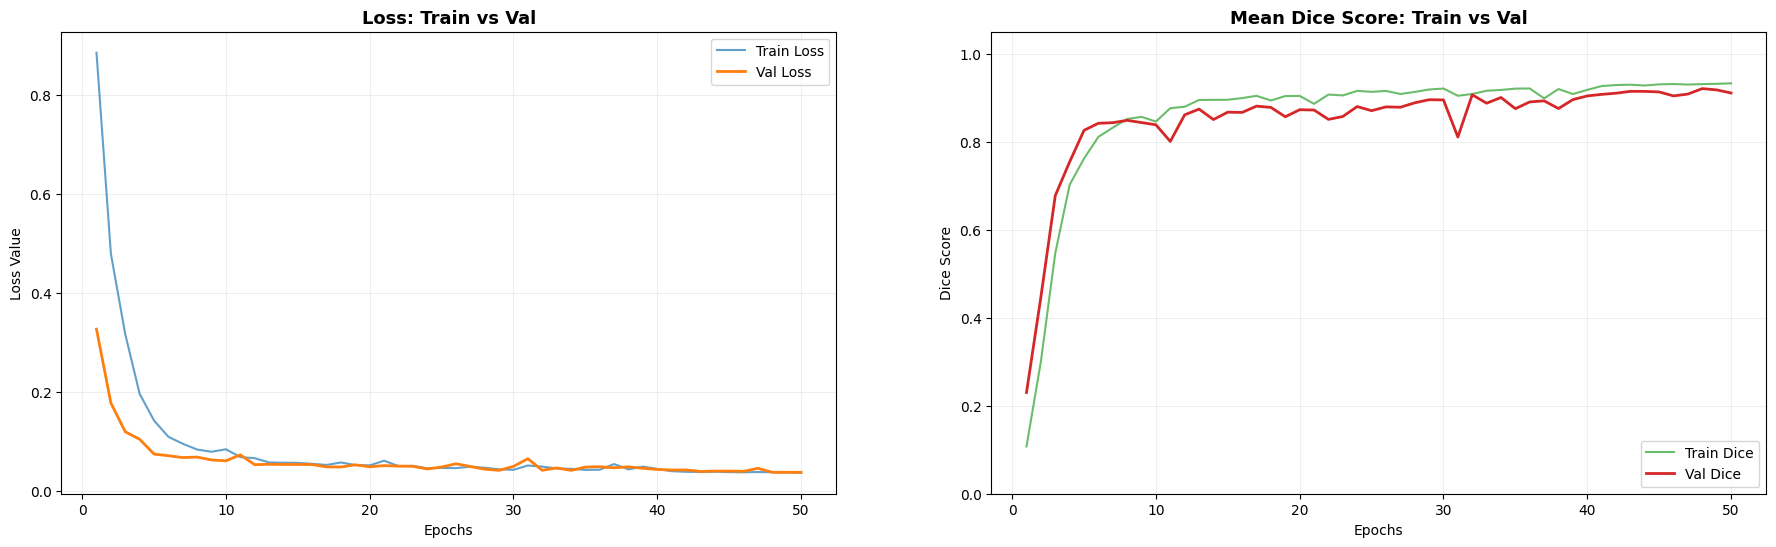

In [12]:
def plot_seg_dashboard(csv_path):
    # 1. 데이터 로드 및 전처리
    df = pd.read_csv(csv_path)
    epochs = df['epoch']
    
    # 클래스별 Dice 컬럼만 추출 (C1~C7)
    class_cols = [f'val_dice_C{i}' for i in range(1, 8)]
    dice_matrix = df[class_cols].values.T  # (7, num_epochs) 형태로 변환
    
    # 2. 그래프 설정 (1행 3열)
    fig, axes = plt.subplots(1, 2, figsize=(22, 6))

    # --- [왼쪽: Loss Trend] ---
    axes[0].plot(epochs, df['train_loss'], label='Train Loss', alpha=0.7)
    axes[0].plot(epochs, df['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_title('Loss: Train vs Val', fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss Value')
    axes[0].legend()
    axes[0].grid(True, alpha=0.2)

    # --- [중앙: Mean Dice Trend] ---
    axes[1].plot(epochs, df['train_dice_mean'], label='Train Dice', alpha=0.7, color='tab:green')
    axes[1].plot(epochs, df['val_dice_mean'], label='Val Dice', linewidth=2, color='tab:red')
    axes[1].set_title('Mean Dice Score: Train vs Val', fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Dice Score')
    axes[1].set_ylim(0, 1.05)
    axes[1].legend(loc='lower right')
    axes[1].grid(True, alpha=0.2)

# --- 실행 ---
plot_seg_dashboard('checkpoints/train_history_fold1.csv')

## 성능 시각화 (dice matrix)

🧠 C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\fold1_val.txt 데이터를 RAM에 로딩 중...


100%|██████████| 18/18 [00:01<00:00, 17.66it/s]


✅ 로딩 완료!
✅ ./checkpoints\best_model_fold1.pth 가중치 로드 및 val_loader 준비 완료!
🧪 혼동 행렬 계산을 위한 픽셀 추출 중...

📊 [Segmentation Performance - IoU]
Background: 0.9971
C1: 0.8612
C2: 0.8998
C3: 0.7922
C4: 0.7401
C5: 0.7615
C6: 0.7992
C7: 0.8341

⭐ Mean IoU (mIoU): 0.8356


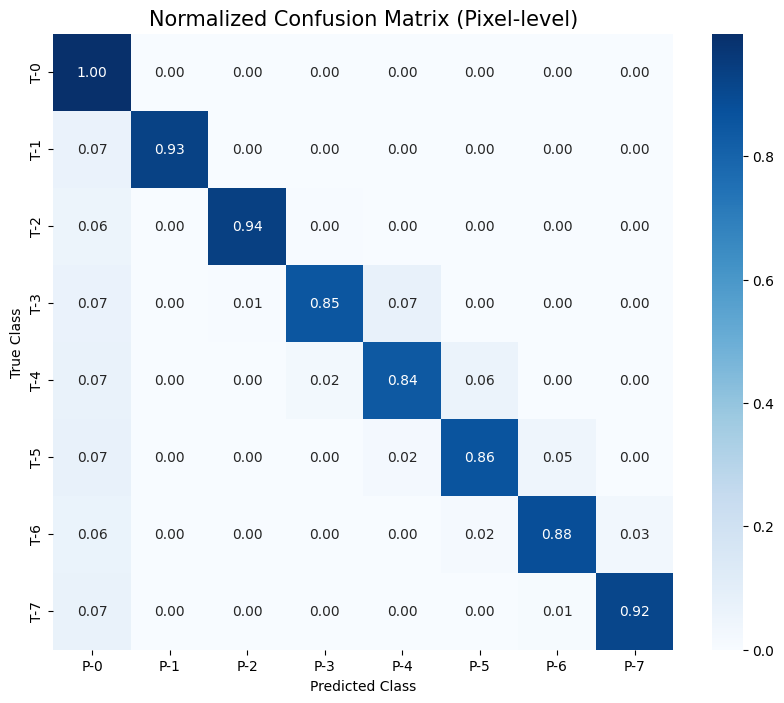

In [8]:
@torch.no_grad()
def plot_seg_confusion_matrix(model, val_loader, device):
    model.eval()
    all_preds = []
    all_trues = []
    
    print("🧪 혼동 행렬 계산을 위한 픽셀 추출 중...")
    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        trues = masks.numpy()
        
        # 픽셀이 너무 많으므로 연산 효율을 위해 1/10 정도로 샘플링해서 추출 가능
        all_preds.append(preds.flatten())
        all_trues.append(trues.flatten())
        
        if len(all_preds) > 50: break # 메모리 보호를 위해 일부 배치만 확인 (필요시 조절)

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_trues)

    # 8x8 매트릭스 생성 (0: 배경, 1~7: C1~C7)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(8)))
    
    # 각 클래스별(행) 비율로 정규화 (전체 픽셀 수 차이 극복)
    cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-6)

    # --- IoU 계산 로직 추가 ---
    # cm은 8x8 행렬 (0: 배경, 1~7: C1~C7)
    
    intersection = np.diag(cm) # 대각선 값 (True Positives)
    ground_truth_set = cm.sum(axis=1) # 각 행의 합 (Actual Positive)
    predicted_set = cm.sum(axis=0) # 각 열의 합 (Predicted Positive)
    union = ground_truth_set + predicted_set - intersection

    # 0으로 나누기 방지 (분모가 0인 경우 1e-6 더함)
    ious = intersection / (union + 1e-6)

    print("\n📊 [Segmentation Performance - IoU]")
    class_names = ['Background', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
    for i, iou in enumerate(ious):
        print(f"{class_names[i]}: {iou:.4f}")

    print(f"\n⭐ Mean IoU (mIoU): {np.mean(ious):.4f}")
    # -----------------------

    # 시각화
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues',
                xticklabels=[f'P-{i}' for i in range(8)], 
                yticklabels=[f'T-{i}' for i in range(8)])
    plt.title('Normalized Confusion Matrix (Pixel-level)', fontsize=15)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()

    
import torch
from torch.utils.data import DataLoader

# 1. 경로 재설정 (이미 설정되어 있다면 확인만 하세요)
VAL_TXT = os.path.join(GOLD_DIR, 'fold1_val.txt') # 분석하고 싶은 폴드 명단

# 2. val_loader 다시 만들기
val_ds = CervicalDataset(
    patient_list_file=VAL_TXT, 
    data_dir=DATA_DIR, 
    transform=get_transforms('val')
)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 3. 모델 다시 만들고 가중치 로드
model = smp.Unet(
    encoder_name="resnet34", 
    encoder_weights="imagenet",
    in_channels=2, 
    classes=8
).to(DEVICE)

# Fold 1의 베스트 모델 가중치 불러오기
best_model_path = os.path.join(SAVE_DIR, 'best_model_fold1.pth')
model.load_state_dict(torch.load(best_model_path))
print(f"✅ {best_model_path} 가중치 로드 및 val_loader 준비 완료!")

# 4. 이제 다시 실행!
plot_seg_confusion_matrix(model, val_loader, DEVICE)

🧪 혼동 행렬 및 성능 지표 계산 중...
⚠️ 메모리 보호를 위해 50 배치까지만 계산합니다.

📊 [Segmentation Performance - IoU & Dice]
Class        | IoU        | Dice      
--------------------------------------
Background   | 0.9971     | 0.9985
C1           | 0.8612     | 0.9254
C2           | 0.8998     | 0.9472
C3           | 0.7922     | 0.8841
C4           | 0.7401     | 0.8507
C5           | 0.7615     | 0.8646
C6           | 0.7992     | 0.8884
C7           | 0.8341     | 0.9095
--------------------------------------
Mean         | 0.8356     | 0.9086
⭐ mIoU: 0.8356
⭐ mDice: 0.9086


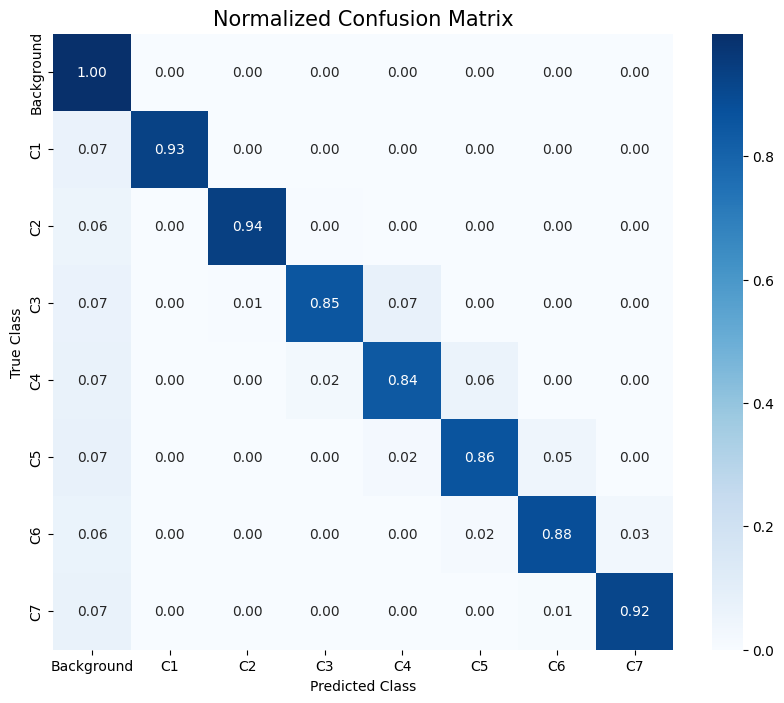

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

@torch.no_grad()
def plot_seg_confusion_matrix(model, val_loader, device):
    model.eval()
    all_preds = []
    all_trues = []
    
    print("🧪 혼동 행렬 및 성능 지표 계산 중...")
    
    # -------------------------------------------------------
    # 1. 픽셀 수집 (기존과 동일)
    # -------------------------------------------------------
    for i, (imgs, masks) in enumerate(val_loader):
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        trues = masks.numpy()
        
        all_preds.append(preds.flatten())
        all_trues.append(trues.flatten())
        
        # 메모리 보호 (필요시 조절)
        if len(all_preds) > 50: 
            print("⚠️ 메모리 보호를 위해 50 배치까지만 계산합니다.")
            break

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_trues)

    # -------------------------------------------------------
    # 2. Confusion Matrix 생성 (기존과 동일)
    # -------------------------------------------------------
    # 0: 배경, 1~7: C1~C7
    cm = confusion_matrix(y_true, y_pred, labels=list(range(8)))
    
    # 시각화용 정규화 CM
    cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-6)

    # -------------------------------------------------------
    # 3. IoU 및 Dice 계산 (✅ 수정된 부분)
    # -------------------------------------------------------
    intersection = np.diag(cm)                  # 교집합 (TP)
    ground_truth_set = cm.sum(axis=1)           # 실제 픽셀 수 (FN + TP)
    predicted_set = cm.sum(axis=0)              # 예측 픽셀 수 (FP + TP)
    
    # (1) IoU 계산
    union = ground_truth_set + predicted_set - intersection
    ious = intersection / (union + 1e-6)

    # (2) Dice Score 계산 (2 * TP / (Actual + Pred))
    dice_numerator = 2 * intersection
    dice_denominator = ground_truth_set + predicted_set
    dices = dice_numerator / (dice_denominator + 1e-6)

    # -------------------------------------------------------
    # 4. 결과 출력
    # -------------------------------------------------------
    print("\n📊 [Segmentation Performance - IoU & Dice]")
    print(f"{'Class':<12} | {'IoU':<10} | {'Dice':<10}")
    print("-" * 38)
    
    class_names = ['Background', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
    
    for i in range(len(class_names)):
        print(f"{class_names[i]:<12} | {ious[i]:.4f}     | {dices[i]:.4f}")

    print("-" * 38)
    print(f"{'Mean':<12} | {np.mean(ious):.4f}     | {np.mean(dices):.4f}")
    print(f"⭐ mIoU: {np.mean(ious):.4f}")
    print(f"⭐ mDice: {np.mean(dices):.4f}")

    # -------------------------------------------------------
    # 5. 시각화 (기존과 동일)
    # -------------------------------------------------------
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues',
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Normalized Confusion Matrix', fontsize=15)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()

# --- 실행 코드 (기존과 동일하게 유지) ---
# model, val_loader, DEVICE가 준비된 상태에서 실행하세요.
plot_seg_confusion_matrix(model, val_loader, DEVICE)

🧪 혼동 행렬 계산을 위한 픽셀 추출 중...


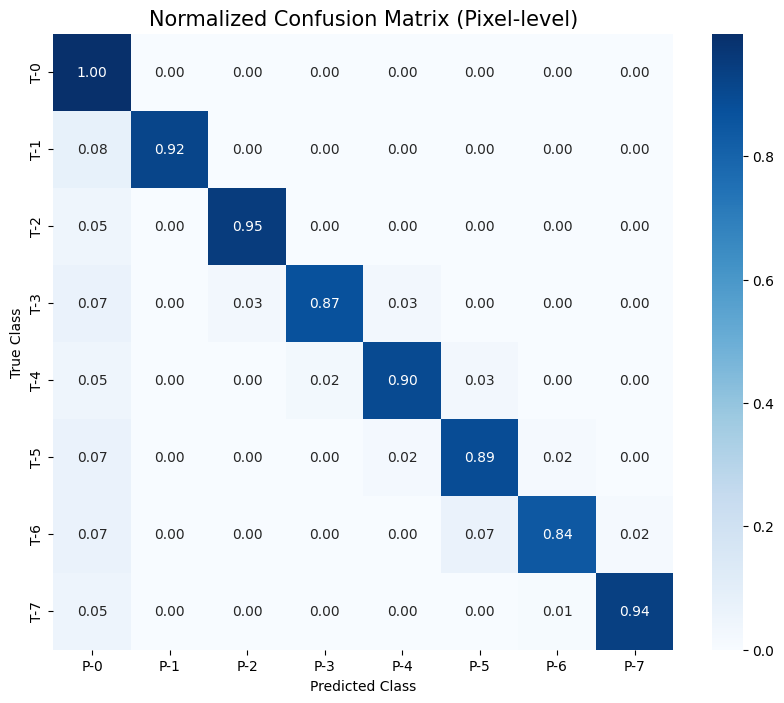

In [ ]:
@torch.no_grad()
def plot_seg_confusion_matrix(model, val_loader, device):
    model.eval()
    all_preds = []
    all_trues = []
    
    print("🧪 혼동 행렬 계산을 위한 픽셀 추출 중...")
    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        trues = masks.numpy()
        
        # 픽셀이 너무 많으므로 연산 효율을 위해 1/10 정도로 샘플링해서 추출 가능
        all_preds.append(preds.flatten())
        all_trues.append(trues.flatten())
        
        if len(all_preds) > 50: break # 메모리 보호를 위해 일부 배치만 확인 (필요시 조절)

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_trues)

    # 8x8 매트릭스 생성 (0: 배경, 1~7: C1~C7)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(8)))
    
    # 각 클래스별(행) 비율로 정규화 (전체 픽셀 수 차이 극복)
    cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-6)

    # 시각화
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues',
                xticklabels=[f'P-{i}' for i in range(8)], 
                yticklabels=[f'T-{i}' for i in range(8)])
    plt.title('Normalized Confusion Matrix (Pixel-level)', fontsize=15)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()

# --- 실행 ---
plot_seg_confusion_matrix(model, val_loader, DEVICE)

## 마스크 시각화

✅ 최적 모델 로드 완료: ./checkpoints/best_model_v2.pth
🧠 C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\val_patients.txt 데이터를 RAM에 로딩 중...


100%|██████████| 18/18 [00:00<00:00, 53.64it/s]


✅ 로딩 완료!


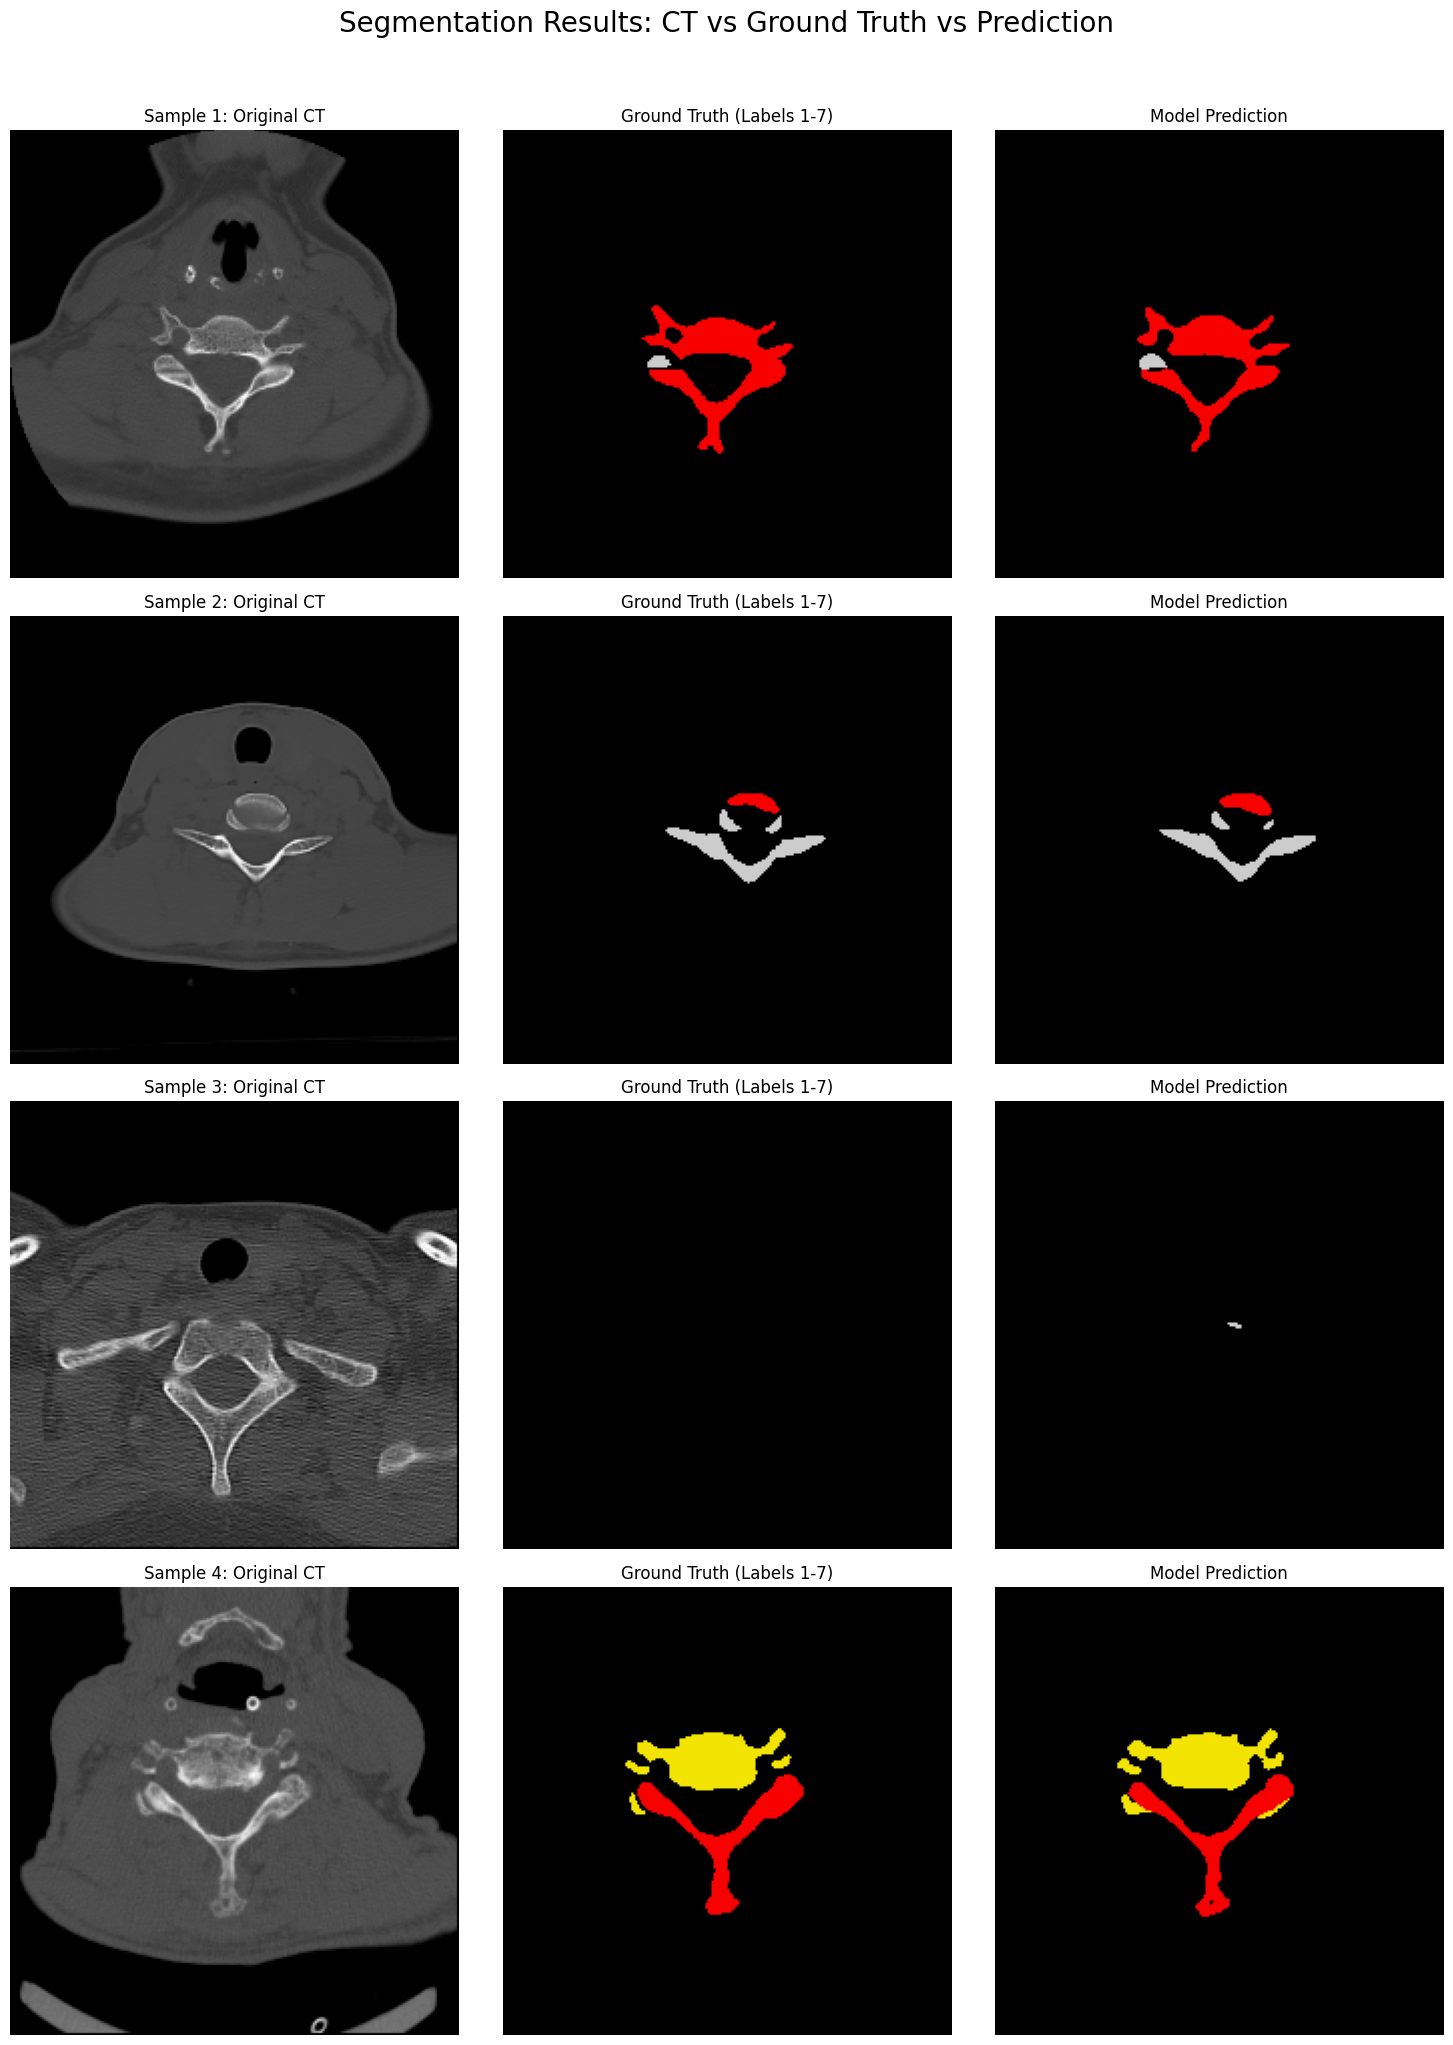

In [ ]:
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    print(f"✅ 최적 모델 로드 완료: {MODEL_PATH}")
else:
    print(f"❌ 모델 파일을 찾을 수 없습니다: {MODEL_PATH}")

# 3. 검증 데이터 로더 준비
val_ds = CervicalDataset(VAL_TXT, DATA_DIR, transform=get_transforms('val'), cache_to_ram=True)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=True) # 4장 랜덤 샘플링

# 4. 추론 및 샘플 시각화
model.eval()
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        outputs = model(imgs)
        # 8개 채널(클래스) 중 확률이 가장 높은 인덱스를 선택
        preds = torch.argmax(outputs, dim=1) 
        break # 첫 번째 배치(4장)만 확인하고 멈춤

# CPU로 데이터 이동
imgs_cpu = imgs.cpu().numpy()
masks_cpu = masks.cpu().numpy()
preds_cpu = preds.cpu().numpy()

# 시각화 실행 (4개 샘플 x 3개 컬럼)
fig, axes = plt.subplots(4, 3, figsize=(15, 20))
plt.suptitle("Segmentation Results: CT vs Ground Truth vs Prediction", fontsize=20, y=1.02)

for i in range(4):
    # [Column 0] 원본 CT (Z-채널 제외하고 0번 채널만 표시)
    axes[i, 0].imshow(imgs_cpu[i, 0], cmap='gray')
    axes[i, 0].set_title(f"Sample {i+1}: Original CT")
    axes[i, 0].axis('off')
    
    # [Column 1] 정답 마스크 (C1~C7 색깔 표시)
    axes[i, 1].imshow(masks_cpu[i], cmap='nipy_spectral', vmin=0, vmax=7)
    axes[i, 1].set_title("Ground Truth (Labels 1-7)")
    axes[i, 1].axis('off')
    
    # [Column 2] 모델 예측 결과
    axes[i, 2].imshow(preds_cpu[i], cmap='nipy_spectral', vmin=0, vmax=7)
    axes[i, 2].set_title("Model Prediction")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

## Inference (1명)

✅ 모델 로드 완료: ./checkpoints/best_model_v2.pth


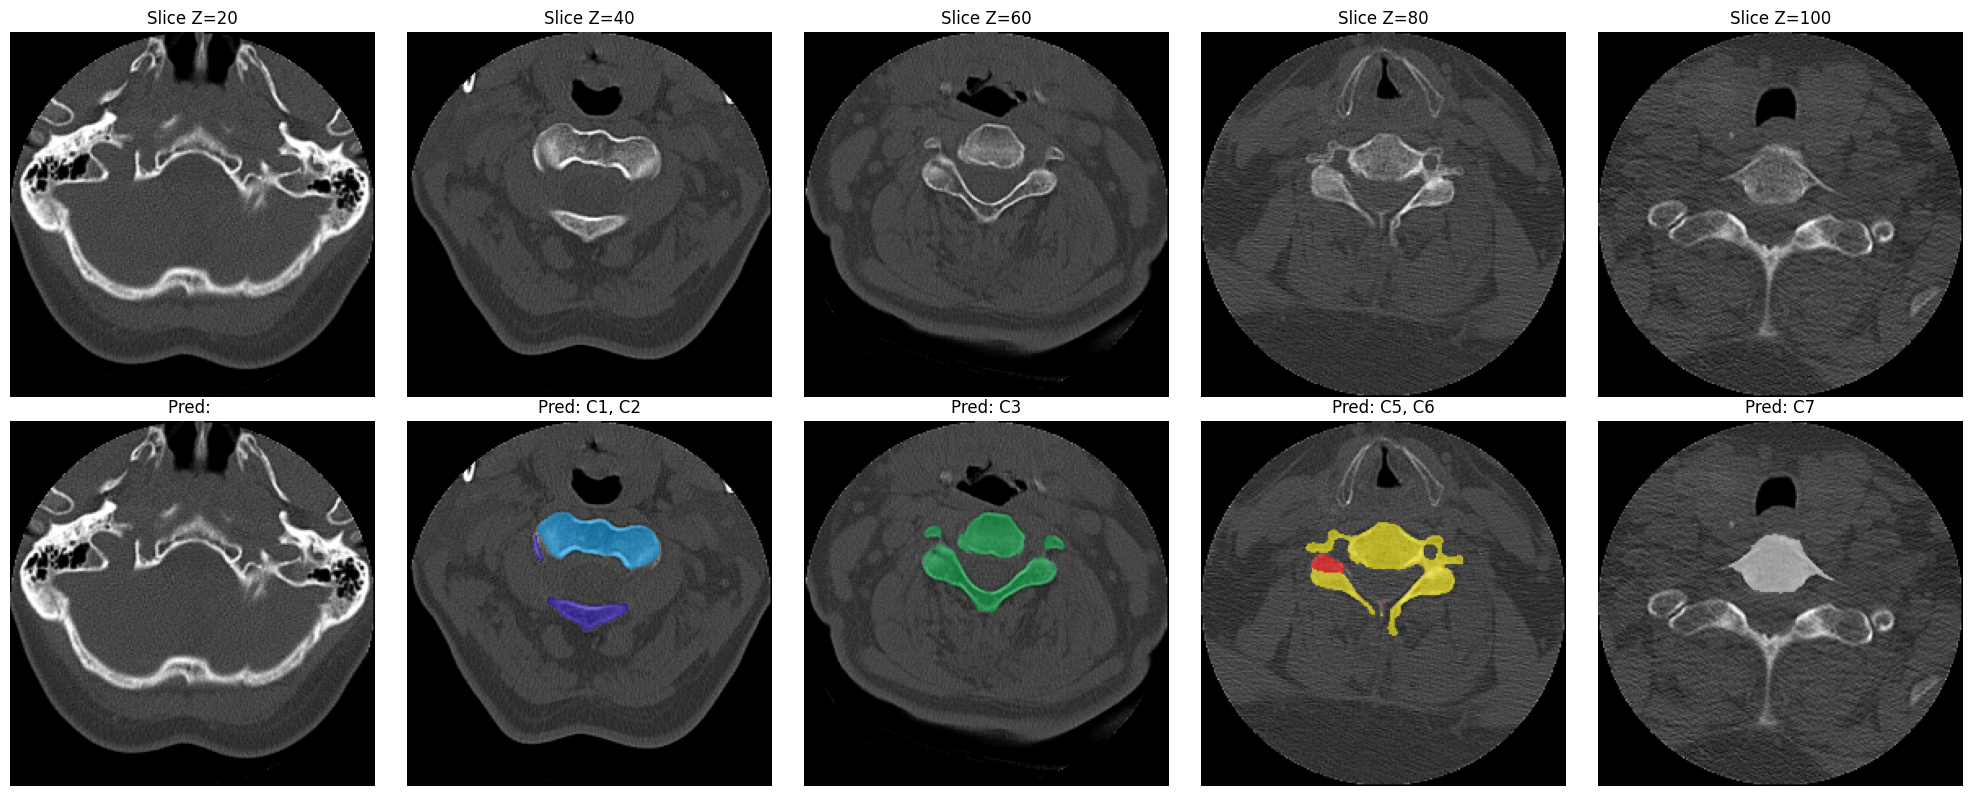

In [ ]:
# --- [1. 설정 및 경로] ---
NEW_PATIENT_DICOM_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\3_only_box\train_images\1.2.826.0.1.3680043.53' 

TARGET_Z, TARGET_SIZE = 128, 224
WL, WW = 500, 2000

# --- [2. 전처리 함수들] ---
def apply_windowing(img, wl, ww):
    img_min, img_max = wl - ww // 2, wl + ww // 2
    img = np.clip(img, img_min, img_max)
    return ((img - img_min) / ww).astype(np.float32)

def preprocess_new_patient(dicom_dir):
    """새로운 환자의 DICOM들을 학습 때와 동일하게 128장 2채널 텐서로 변환"""
    dcm_files = [f for f in os.listdir(dicom_dir) if f.endswith('.dcm')]
    dcm_data = []

    for f in dcm_files:
        ds = pydicom.dcmread(os.path.join(dicom_dir, f), stop_before_pixels=True)
        dcm_data.append({
            'path': os.path.join(dicom_dir, f),
            'z_pos': float(ds.ImagePositionPatient[2]),
            'slope': float(ds.RescaleSlope) if 'RescaleSlope' in ds else 1.0,
            'intercept': float(ds.RescaleIntercept) if 'RescaleIntercept' in ds else 0.0
        })

    # 물리 좌표 정렬 (머리 -> 발)
    dcm_data.sort(key=lambda x: x['z_pos'], reverse=True)

    imgs = []
    for item in dcm_data:
        ds = pydicom.dcmread(item['path'])
        img = ds.pixel_array.astype(np.float32) * item['slope'] + item['intercept']
        imgs.append(img)

    img_vol = np.stack(imgs, axis=0)
    # 윈도잉 적용
    img_vol = apply_windowing(img_vol, WL, WW)
    
    # 리사이징 (128, 224, 224)
    z_factor = TARGET_Z / img_vol.shape[0]
    xy_factor = TARGET_SIZE / img_vol.shape[1]
    img_vol = zoom(img_vol, (z_factor, xy_factor, xy_factor), order=1)
    
    return img_vol

# --- [3. 모델 로드] ---
model = smp.Unet(
    encoder_name="resnet34",
    in_channels=2, 
    classes=8
).to(DEVICE)

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print(f"✅ 모델 로드 완료: {MODEL_PATH}")

# --- [4. 추론 실행] ---
with torch.no_grad():
    # 이미지 전처리
    input_vol = preprocess_new_patient(NEW_PATIENT_DICOM_DIR) # (128, 224, 224)
    
    preds = []
    for z in range(TARGET_Z):
        img_slice = torch.from_numpy(input_vol[z]).unsqueeze(0) # (1, 224, 224)
        
        # Z-position 채널 추가
        z_pos = z / (TARGET_Z - 1)
        z_channel = torch.full((1, TARGET_SIZE, TARGET_SIZE), z_pos)
        
        # 2채널 입력 생성 (1, 2, 224, 224)
        input_tensor = torch.cat([img_slice, z_channel], dim=0).unsqueeze(0).to(DEVICE)
        
        # 예측
        output = model(input_tensor)
        # 클래스 확률 중 가장 높은 것 선택 (Argmax)
        pred = torch.argmax(output, dim=1).cpu().numpy()[0]
        preds.append(pred)

    pred_vol = np.stack(preds, axis=0) # (128, 224, 224)

# --- [5. 시각화] ---
# 주요 지점 5개 슬라이스 시각화
indices = np.linspace(20, 100, 5, dtype=int)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

v_map = {0:'BG', 1:'C1', 2:'C2', 3:'C3', 4:'C4', 5:'C5', 6:'C6', 7:'C7'}

for i, z in enumerate(indices):
    axes[0, i].imshow(input_vol[z], cmap='gray')
    axes[0, i].set_title(f"Slice Z={z}")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(input_vol[z], cmap='gray')
    mask = pred_vol[z]
    if np.any(mask > 0):
        masked = np.ma.masked_where(mask == 0, mask)
        axes[1, i].imshow(masked, cmap='nipy_spectral', alpha=0.6, vmin=0, vmax=7)
    
    found = [v_map[l] for l in np.unique(mask) if l > 0]
    axes[1, i].set_title(f"Pred: {', '.join(found)}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## 수도 마스크 생성

In [ ]:
import os
import torch
import numpy as np
import pydicom
import SimpleITK as sitk
from scipy.ndimage import zoom
from tqdm import tqdm
import segmentation_models_pytorch as smp

# --- [1. 경로 및 설정] ---
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
MODEL_PATH = os.path.join(BASE_DIR, 'checkpoints', 'best_model_fold1.pth')
MASK_SAVE_ROOT = os.path.join(BASE_DIR, 'seg_results_masks')

# 성공했던 규격
TARGET_Z, TARGET_SIZE = 128, 224
WL, WW = 500, 2000
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

os.makedirs(MASK_SAVE_ROOT, exist_ok=True)

# --- [2. 유틸리티 함수] ---
def apply_windowing(img, wl, ww):
    img_min, img_max = wl - ww // 2, wl + ww // 2
    img = np.clip(img, img_min, img_max)
    return ((img - img_min) / ww).astype(np.float32)

# --- [3. 모델 로드] ---
model = smp.Unet(encoder_name="resnet34", in_channels=2, classes=8).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print(f"✅ 모델 로드 완료: {MODEL_PATH}")

# --- [4. 메인 처리 함수] ---
def run_smart_factory():
    # 처리할 두 그룹 (1_mask_and_box, 3_only_box)
    groups = ['1_mask_and_box', '3_only_box']
    
    for group in groups:
        group_path = os.path.join(BASE_DIR, group, 'train_images')
        if not os.path.exists(group_path): continue
        
        uids = [d for d in os.listdir(group_path) if os.path.isdir(os.path.join(group_path, d))]
        print(f"\n📦 [{group}] 그룹 처리 시작 ({len(uids)}명)")

        for uid in tqdm(uids):
            save_path = os.path.join(MASK_SAVE_ROOT, f"{uid}_mask.nii.gz")
            if os.path.exists(save_path): continue

            try:
                # [Step A] DICOM 로드 및 원본 정보 수집 (사용자님 로직 그대로)
                dicom_dir = os.path.join(group_path, uid)
                dcm_files = [f for f in os.listdir(dicom_dir) if f.endswith('.dcm')]
                dcm_data = []
                for f in dcm_files:
                    ds = pydicom.dcmread(os.path.join(dicom_dir, f), stop_before_pixels=True)
                    dcm_data.append({
                        'path': os.path.join(dicom_dir, f),
                        'z_pos': float(ds.ImagePositionPatient[2]),
                        'slope': float(ds.RescaleSlope) if 'RescaleSlope' in ds else 1.0,
                        'intercept': float(ds.RescaleIntercept) if 'RescaleIntercept' in ds else 0.0
                    })
                
                # 물리 좌표 정렬 (머리 -> 발)
                dcm_data.sort(key=lambda x: x['z_pos'], reverse=True)
                orig_z = len(dcm_data)

                # 실제 픽셀 로드 (최소한의 메모리 유지를 위해 필요할 때 로드)
                imgs = []
                for item in dcm_data:
                    ds = pydicom.dcmread(item['path'])
                    img = ds.pixel_array.astype(np.float32) * item['slope'] + item['intercept']
                    imgs.append(img)
                
                orig_vol = np.stack(imgs, axis=0) # (Original_Z, 512, 512)
                orig_h, orig_w = orig_vol.shape[1], orig_vol.shape[2]

                # [Step B] 128x224x224로 리샘플링 (모델 최적화)
                vol_win = apply_windowing(orig_vol, WL, WW)
                z_factor = TARGET_Z / orig_z
                xy_factor = TARGET_SIZE / orig_h
                input_vol = zoom(vol_win, (z_factor, xy_factor, xy_factor), order=1)

                # [Step C] 128장 추론 루프
                preds_128 = []
                with torch.no_grad():
                    for z in range(TARGET_Z):
                        img_slice = torch.from_numpy(input_vol[z]).unsqueeze(0)
                        z_pos = z / (TARGET_Z - 1)
                        z_channel = torch.full((1, TARGET_SIZE, TARGET_SIZE), z_pos)
                        
                        input_tensor = torch.cat([img_slice, z_channel], dim=0).unsqueeze(0).to(DEVICE)
                        output = model(input_tensor)
                        pred = torch.argmax(output, dim=1).cpu().numpy()[0]
                        preds_128.append(pred.astype(np.uint8))
                
                mask_128 = np.stack(preds_128, axis=0)

                # [Step D] 원본 규격으로 복원 (Nearest interpolation 필수!)
                # (128, 224, 224) -> (Original_Z, Original_H, Original_W)
                final_z_f = orig_z / TARGET_Z
                final_xy_f = orig_h / TARGET_SIZE
                full_mask = zoom(mask_128, (final_z_f, final_xy_f, final_xy_f), order=0)

                # [Step E] NIfTI 저장 (메타데이터는 정렬된 DICOM 기반으로 생성)
                mask_img = sitk.GetImageFromArray(full_mask)
                # Spacing 정보 등은 정밀도를 위해 일단 기본값으로 하되, 
                # 필요시 원본 DICOM 정보를 이식할 수 있습니다.
                sitk.WriteImage(mask_img, save_path)

            except Exception as e:
                print(f"❌ {uid} 실패: {e}")

run_smart_factory()

✅ 모델 로드 완료: C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\checkpoints\best_model_v2.pth

📦 [1_mask_and_box] 그룹 처리 시작 (40명)


100%|██████████| 40/40 [03:20<00:00,  5.00s/it]



📦 [3_only_box] 그룹 처리 시작 (195명)


100%|██████████| 195/195 [14:31<00:00,  4.47s/it]


In [ ]:
import numpy as np
import SimpleITK as sitk

GT_DIR = os.path.join(BASE_DIR, '1_mask_and_box', 'segmentations')

def detect_alignment_fault(pid):
    # 1. 로드
    gt_img = sitk.ReadImage(os.path.join(GT_DIR, f"{pid}.nii.gz"))
    pred_img = sitk.ReadImage(os.path.join(MASK_SAVE_ROOT, f"{pid}_mask.nii.gz"))
    
    gt_vol = sitk.GetArrayFromImage(gt_img).astype(np.uint8)
    pred_vol = sitk.GetArrayFromImage(pred_img).astype(np.uint8)
    
    # 2. 테스트 시나리오
    scenarios = {
        "Original": pred_vol,
        "Z-Flip (Slice Order)": np.flip(pred_vol, axis=0),
        "Y-Flip (Up-Down)": np.flip(pred_vol, axis=1),
        "Z + Y Flip": np.flip(np.flip(pred_vol, axis=0), axis=1)
    }
    
    print(f"📊 [{pid}] 정렬 테스트 결과:")
    for name, vol in scenarios.items():
        # C1~C7에 대해 하나라도 겹치는지 체크
        intersection = np.logical_and(vol > 0, gt_vol > 0).sum()
        union = (vol > 0).sum() + (gt_vol > 0).sum()
        dice = (2. * intersection) / (union + 1e-7)
        print(f" - {name:20}: Dice {dice:.4f}")

# 40명 중 한 명에게 바로 돌려보세요!
detect_alignment_fault("1.2.826.0.1.3680043.780")

📊 [1.2.826.0.1.3680043.780] 정렬 테스트 결과:
 - Original            : Dice 0.1738
 - Z-Flip (Slice Order): Dice 0.3179
 - Y-Flip (Up-Down)    : Dice 0.2346
 - Z + Y Flip          : Dice 0.8410


## 수도 마스크 교정

In [ ]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
from tqdm import tqdm

# --- [1. 경로 설정] ---
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
# 교정할 마스크들이 있는 폴더
PRED_DIR = os.path.join(BASE_DIR, 'seg_results_masks')
# 교정된 마스크를 저장할 폴더 (안전을 위해 새 폴더 추천)
FIXED_DIR = os.path.join(BASE_DIR, 'seg_pseudo_masks')
# 정답 마스크 폴더 (40명 검증용)
GT_DIR = os.path.join(BASE_DIR, '1_mask_and_box', 'segmentations')

os.makedirs(FIXED_DIR, exist_ok=True)

# --- [2. 235명 전원 마스크 교정 루프] ---
pred_files = [f for f in os.listdir(PRED_DIR) if f.endswith('.nii.gz')]
print(f"🚀 235명 마스크 교정 시작 (Z + Y Flip 적용)")

for f_name in tqdm(pred_files, desc="Fixing Axes"):
    save_path = os.path.join(FIXED_DIR, f_name)
    if os.path.exists(save_path): continue
        
    try:
        # NIfTI 로드
        img = sitk.ReadImage(os.path.join(PRED_DIR, f_name))
        vol = sitk.GetArrayFromImage(img)
        
        # [핵심] 진단 결과에 따른 축 뒤집기 (Z: axis 0, Y: axis 1)
        # np.flip은 배열의 순서를 뒤집습니다.
        fixed_vol = np.flip(vol, axis=(0, 1))
        
        # 다시 NIfTI로 변환 및 정보 복사
        fixed_img = sitk.GetImageFromArray(fixed_vol)
        fixed_img.CopyInformation(img)
        sitk.WriteImage(fixed_img, save_path)
        
    except Exception as e:
        print(f"❌ {f_name} 교정 실패: {e}")

# --- [3. 40명 최종 Dice 검증] ---
print("\n📊 40명 Gold Patient 최종 검증 중...")
dice_results = []
gt_files = [f for f in os.listdir(GT_DIR) if f.endswith(('.nii.gz', '.nii'))]

for f_name in tqdm(gt_files, desc="Evaluating"):
    pid = f_name.replace('.nii.gz', '').replace('.nii', '')
    pred_path = os.path.join(FIXED_DIR, f"{pid}_mask.nii.gz")
    
    if os.path.exists(pred_path):
        gt_vol = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(GT_DIR, f_name)))
        pred_vol = sitk.GetArrayFromImage(sitk.ReadImage(pred_path))
        
        scores = []
        for c in range(1, 8):
            p = (pred_vol == c).astype(float)
            t = (gt_vol == c).astype(float)
            if np.sum(t) == 0: continue
            score = (2. * np.sum(p * t)) / (np.sum(p) + np.sum(t) + 1e-7)
            scores.append(score)
        
        dice_results.append({'pid': pid, 'Mean_Dice': np.mean(scores)})

df_eval = pd.DataFrame(dice_results)
print(f"\n✨ 최종 검증 완료! 평균 Dice: {df_eval['Mean_Dice'].mean():.4f}")

🚀 235명 마스크 교정 시작 (Z + Y Flip 적용)


Fixing Axes: 100%|██████████| 235/235 [00:00<00:00, 78601.39it/s]



📊 40명 Gold Patient 최종 검증 중...


Evaluating: 100%|██████████| 40/40 [03:35<00:00,  5.40s/it]


✨ 최종 검증 완료! 평균 Dice: 0.9124


## 수도 마스크 검증

🔍 검증 대상 GT 파일: 40개 발견


성능 평가 중: 100%|██████████| 40/40 [04:24<00:00,  6.61s/it]



🏆 CLASS-WISE DICE SCORE (Average)
--------------------------------------------------
C1    0.9164
C2    0.9316
C3    0.8999
C4    0.9003
C5    0.9068
C6    0.9109
C7    0.9212
dtype: float32

⭐ 전체 평균 Dice: 0.9124


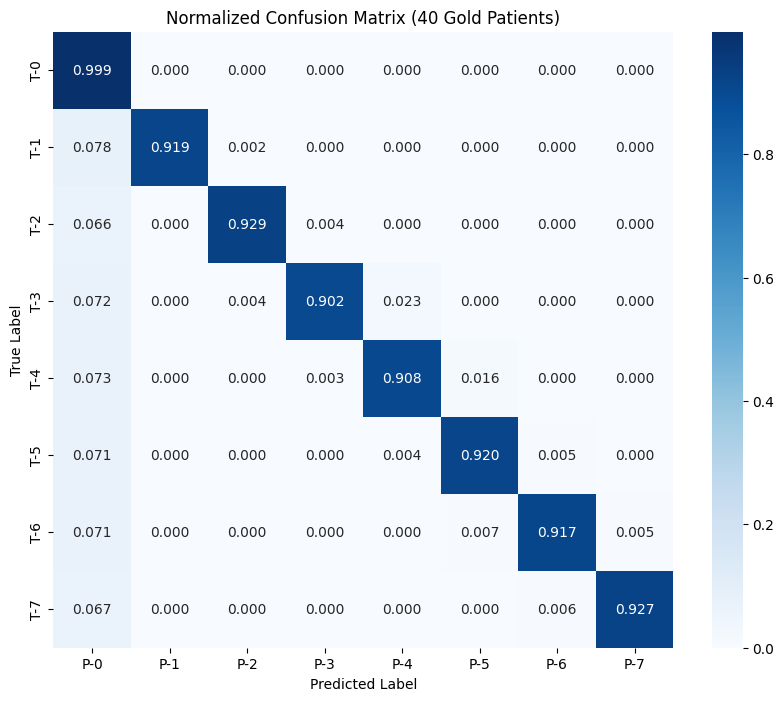

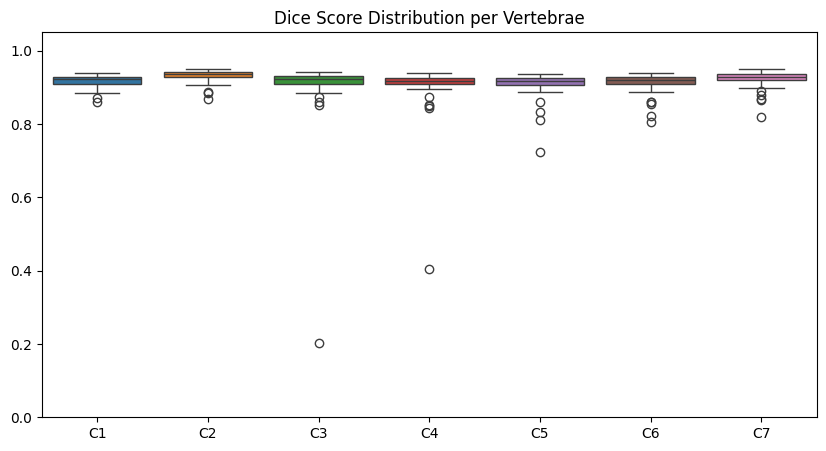

📊 상세 결과가 저장되었습니다: evaluation_results.csv


In [ ]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm


GT_MASK_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\1_mask_and_box\segmentations'

def calculate_dice_per_class(pred, target, num_classes=8):
    dice_scores = []
    for cls in range(num_classes):
        p = (pred == cls).astype(np.float32)
        t = (target == cls).astype(np.float32)
        intersection = np.sum(p * t)
        union = np.sum(p) + np.sum(t)
        # 분모가 0인 경우 1.0으로 처리 (둘 다 없는 경우)
        dice = (2.0 * intersection) / (union + 1e-7) if union > 0 else 1.0
        dice_scores.append(dice)
    return dice_scores

def run_evaluation_40():
    results = []
    all_y_true = []
    all_y_pred = []
    
    # 1. 정답 파일 목록 (1.2.3.nii.gz 형태)
    gt_files = [f for f in os.listdir(GT_MASK_DIR) if f.endswith(('.nii.gz', '.nii'))]
    print(f"🔍 검증 대상 GT 파일: {len(gt_files)}개 발견")

    for f_name in tqdm(gt_files, desc="성능 평가 중"):
        pid = f_name.replace('.nii.gz', '').replace('.nii', '')
        
        # 예측 파일명 확인 (저장 시 {pid}_mask.nii.gz 규격 사용 가정)
        pred_path = os.path.join(FIXED_DIR, f"{pid}_mask.nii.gz")
        
        if not os.path.exists(pred_path):
            # 만약 _mask가 안 붙어 있다면 f"{pid}.nii.gz"로도 시도
            pred_path = os.path.join(FIXED_DIR, f"{pid}.nii.gz")
            if not os.path.exists(pred_path):
                continue
            
        try:
            # SimpleITK로 볼륨 로드
            gt_vol = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(GT_MASK_DIR, f_name))).astype(np.uint8)
            pred_vol = sitk.GetArrayFromImage(sitk.ReadImage(pred_path)).astype(np.uint8)
            
            # Dice 계산
            dice_scores = calculate_dice_per_class(pred_vol, gt_vol)
            res = {'pid': pid}
            for i, s in enumerate(dice_scores):
                res[f'C{i}' if i > 0 else 'BG'] = s
            res['Mean_Dice'] = np.mean(dice_scores[1:]) # 배경 제외 평균
            results.append(res)
            
            # Confusion Matrix용 데이터 샘플링 (메모리 보호를 위해 1%만 추출)
            gt_flat = gt_vol.flatten()
            pred_flat = pred_vol.flatten()
            idx = np.random.choice(len(gt_flat), int(len(gt_flat) * 0.01), replace=False)
            all_y_true.append(gt_flat[idx])
            all_y_pred.append(pred_flat[idx])
            
        except Exception as e:
            print(f"❌ {pid} 처리 실패: {e}")

    if not results:
        print("❌ 매칭된 파일이 없습니다. MASK_SAVE_ROOT의 파일명을 확인하세요.")
        return

    # 결과 데이터프레임 생성
    df_res = pd.DataFrame(results)
    
    # --- [시각화 및 요약] ---
    print("\n" + "="*50)
    print("🏆 CLASS-WISE DICE SCORE (Average)")
    print("-" * 50)
    summary = df_res[[f'C{i}' for i in range(1, 8)]].mean()
    print(summary.round(4))
    print(f"\n⭐ 전체 평균 Dice: {df_res['Mean_Dice'].mean():.4f}")
    print("="*50)

    # Confusion Matrix 시각화
    y_true = np.concatenate(all_y_true)
    y_pred = np.concatenate(all_y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(8)))
    cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-7)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=True, fmt=".3f", cmap='Blues',
                xticklabels=[f'P-{i}' for i in range(8)],
                yticklabels=[f'T-{i}' for i in range(8)])
    plt.title('Normalized Confusion Matrix (40 Gold Patients)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # 결과 저장
    df_res.to_csv(os.path.join(BASE_DIR, 'evaluation_results.csv'), index=False)
    print(f"📊 상세 결과가 저장되었습니다: evaluation_results.csv")

# 실행
run_evaluation_40()

## 수도 마스크 생성 (2트)

In [16]:
import os
import torch
import numpy as np
import pydicom
import SimpleITK as sitk
from scipy.ndimage import zoom
from tqdm import tqdm
import segmentation_models_pytorch as smp
import torch.nn.functional as F

# --- [1. 경로 및 설정] ---
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
WEIGHTS_DIR = os.path.join(BASE_DIR, 'checkpoints') # fold1~5 pth 파일이 있는 곳
MASK_SAVE_ROOT = os.path.join(BASE_DIR, 'seg_pseudo_masks') # 최종 결과 폴더

GROUPS = ['1_mask_and_box', '3_only_box']
TARGET_Z, TARGET_SIZE = 128, 224
WL, WW = 500, 2000
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

os.makedirs(MASK_SAVE_ROOT, exist_ok=True)

# --- [2. 모델 5개 로드] ---
models = []
for f in range(1, 6):
    model_path = os.path.join(WEIGHTS_DIR, f'best_model_fold{f}.pth')
    m = smp.Unet(encoder_name="resnet34", in_channels=2, classes=8).to(DEVICE)
    m.load_state_dict(torch.load(model_path, map_location=DEVICE))
    m.eval()
    models.append(m)
print(f"✅ 5-Fold 모델 앙상블 준비 완료")

# --- [3. 유틸리티 함수] ---
def apply_windowing(img, wl, ww):
    img_min, img_max = wl - ww // 2, wl + ww // 2
    img = np.clip(img, img_min, img_max)
    return ((img - img_min) / ww).astype(np.float32)

# --- [4. 메인 앙상블 추론 루프] ---
@torch.no_grad()
def run_ensemble_factory():
    for group in GROUPS:
        group_path = os.path.join(BASE_DIR, group, 'train_images')
        if not os.path.exists(group_path): continue
        
        uids = [d for d in os.listdir(group_path) if os.path.isdir(os.path.join(group_path, d))]
        print(f"\n📦 [{group}] 그룹 앙상블 시작")

        for uid in tqdm(uids):
            save_path = os.path.join(MASK_SAVE_ROOT, f"{uid}_mask.nii.gz")
            if os.path.exists(save_path): continue

            try:
                # [Step A] DICOM 로드 및 정렬 (Superior -> Inferior)
                dicom_dir = os.path.join(group_path, uid)
                dcm_files = sorted(os.listdir(dicom_dir))
                dcm_data = []
                for f in dcm_files:
                    ds = pydicom.dcmread(os.path.join(dicom_dir, f))
                    dcm_data.append({
                        'pixel': ds.pixel_array.astype(np.float32) * float(getattr(ds, 'RescaleSlope', 1)) + float(getattr(ds, 'RescaleIntercept', 0)),
                        'z_pos': float(ds.ImagePositionPatient[2])
                    })
                
                # Z축 기준 정렬 (머리 -> 발)
                dcm_data.sort(key=lambda x: x['z_pos'], reverse=True)
                orig_vol = np.stack([x['pixel'] for x in dcm_data], axis=0)
                orig_z, orig_h, orig_w = orig_vol.shape

                # [Step B] 전처리 (128x224x224)
                vol_win = apply_windowing(orig_vol, WL, WW)
                input_vol = zoom(vol_win, (TARGET_Z/orig_z, TARGET_SIZE/orig_h, TARGET_SIZE/orig_w), order=1)

                # [Step C] 앙상블 추론 (Soft Voting)
                # 확률을 누적할 빈 그릇 [Z, Classes, H, W]
                ensemble_probs = np.zeros((TARGET_Z, 8, TARGET_SIZE, TARGET_SIZE), dtype=np.float32)

                for z in range(TARGET_Z):
                    img_slice = torch.from_numpy(input_vol[z]).unsqueeze(0)
                    z_pos = torch.full((1, TARGET_SIZE, TARGET_SIZE), z / (TARGET_Z - 1))
                    input_tensor = torch.cat([img_slice, z_pos], dim=0).unsqueeze(0).to(DEVICE)

                    # 5개 모델의 결과를 합산
                    combined_prob = torch.zeros((1, 8, TARGET_SIZE, TARGET_SIZE)).to(DEVICE)
                    for m in models:
                        output = m(input_tensor)
                        combined_prob += F.softmax(output, dim=1)
                    
                    ensemble_probs[z] = (combined_prob / 5.0).cpu().numpy()[0]

                # 최종 클래스 결정
                mask_128 = np.argmax(ensemble_probs, axis=1).astype(np.uint8)

                # [Step D] 원본 복원 및 축 교정 (Z+Y Flip 적용)
                # 🎯 여기서 바로 flip을 적용하여 나중에 따로 작업할 필요 없게 합니다.
                full_mask = zoom(mask_128, (orig_z/TARGET_Z, orig_h/TARGET_SIZE, orig_w/TARGET_SIZE), order=0)
                
                # 사용자님이 발견하신 '축 뒤집기' 적용
                full_mask = np.flip(full_mask, axis=(0, 1))

                # [Step E] NIfTI 저장
                mask_img = sitk.GetImageFromArray(full_mask)
                sitk.WriteImage(mask_img, save_path)

            except Exception as e:
                print(f"❌ {uid} 처리 실패: {e}")

if __name__ == '__main__':
    run_ensemble_factory()
    print("\n✨ 235명 전원에 대한 앙상블 마스크 생성이 완료되었습니다!")

✅ 5-Fold 모델 앙상블 준비 완료

📦 [1_mask_and_box] 그룹 앙상블 시작


100%|██████████| 40/40 [04:45<00:00,  7.14s/it]



📦 [3_only_box] 그룹 앙상블 시작


100%|██████████| 195/195 [20:51<00:00,  6.42s/it]


✨ 235명 전원에 대한 앙상블 마스크 생성이 완료되었습니다!


## 수도 마스크 검증 (2트)

🔍 검증 대상 GT 파일: 40개 발견


성능 평가 중: 100%|██████████| 40/40 [04:34<00:00,  6.87s/it]



🏆 CLASS-WISE DICE SCORE (Average)
--------------------------------------------------
C1    0.9184
C2    0.9327
C3    0.9167
C4    0.9138
C5    0.9126
C6    0.9146
C7    0.9260
dtype: float32

⭐ 전체 평균 Dice: 0.9193


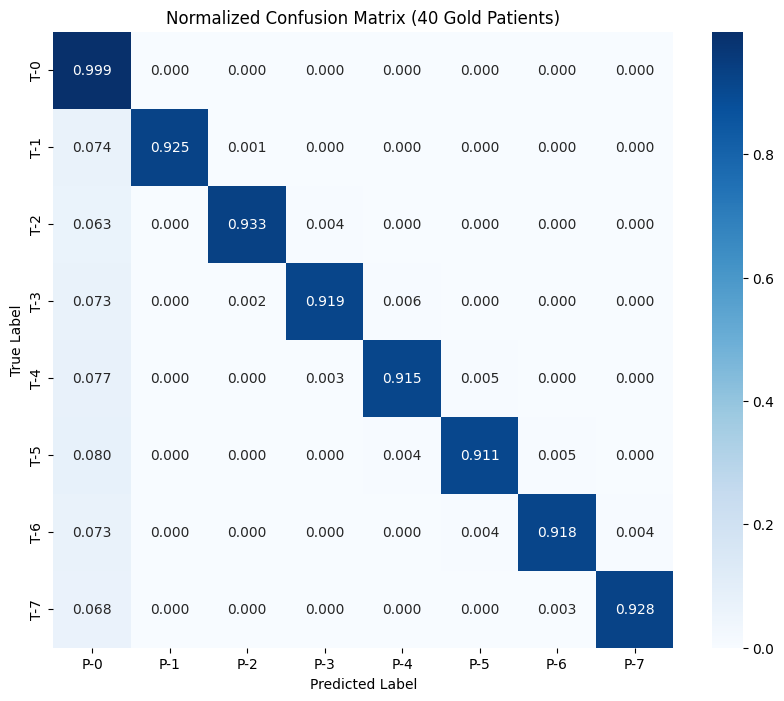

📊 상세 결과가 저장되었습니다: evaluation_results_.csv


In [18]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm


GT_MASK_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\1_mask_and_box\segmentations'

def calculate_dice_per_class(pred, target, num_classes=8):
    dice_scores = []
    for cls in range(num_classes):
        p = (pred == cls).astype(np.float32)
        t = (target == cls).astype(np.float32)
        intersection = np.sum(p * t)
        union = np.sum(p) + np.sum(t)
        # 분모가 0인 경우 1.0으로 처리 (둘 다 없는 경우)
        dice = (2.0 * intersection) / (union + 1e-7) if union > 0 else 1.0
        dice_scores.append(dice)
    return dice_scores

def run_evaluation_40():
    results = []
    all_y_true = []
    all_y_pred = []
    
    # 1. 정답 파일 목록 (1.2.3.nii.gz 형태)
    gt_files = [f for f in os.listdir(GT_MASK_DIR) if f.endswith(('.nii.gz', '.nii'))]
    print(f"🔍 검증 대상 GT 파일: {len(gt_files)}개 발견")

    for f_name in tqdm(gt_files, desc="성능 평가 중"):
        pid = f_name.replace('.nii.gz', '').replace('.nii', '')
        
        # 예측 파일명 확인 (저장 시 {pid}_mask.nii.gz 규격 사용 가정)
        pred_path = os.path.join(MASK_SAVE_ROOT, f"{pid}_mask.nii.gz")
        
        if not os.path.exists(pred_path):
            # 만약 _mask가 안 붙어 있다면 f"{pid}.nii.gz"로도 시도
            pred_path = os.path.join(MASK_SAVE_ROOT, f"{pid}.nii.gz")
            if not os.path.exists(pred_path):
                continue
            
        try:
            # SimpleITK로 볼륨 로드
            gt_vol = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(GT_MASK_DIR, f_name))).astype(np.uint8)
            pred_vol = sitk.GetArrayFromImage(sitk.ReadImage(pred_path)).astype(np.uint8)
            
            # Dice 계산
            dice_scores = calculate_dice_per_class(pred_vol, gt_vol)
            res = {'pid': pid}
            for i, s in enumerate(dice_scores):
                res[f'C{i}' if i > 0 else 'BG'] = s
            res['Mean_Dice'] = np.mean(dice_scores[1:]) # 배경 제외 평균
            results.append(res)
            
            # Confusion Matrix용 데이터 샘플링 (메모리 보호를 위해 1%만 추출)
            gt_flat = gt_vol.flatten()
            pred_flat = pred_vol.flatten()
            idx = np.random.choice(len(gt_flat), int(len(gt_flat) * 0.01), replace=False)
            all_y_true.append(gt_flat[idx])
            all_y_pred.append(pred_flat[idx])
            
        except Exception as e:
            print(f"❌ {pid} 처리 실패: {e}")

    if not results:
        print("❌ 매칭된 파일이 없습니다. MASK_SAVE_ROOT의 파일명을 확인하세요.")
        return

    # 결과 데이터프레임 생성
    df_res = pd.DataFrame(results)
    
    # --- [시각화 및 요약] ---
    print("\n" + "="*50)
    print("🏆 CLASS-WISE DICE SCORE (Average)")
    print("-" * 50)
    summary = df_res[[f'C{i}' for i in range(1, 8)]].mean()
    print(summary.round(4))
    print(f"\n⭐ 전체 평균 Dice: {df_res['Mean_Dice'].mean():.4f}")
    print("="*50)

    # Confusion Matrix 시각화
    y_true = np.concatenate(all_y_true)
    y_pred = np.concatenate(all_y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(8)))
    cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-7)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=True, fmt=".3f", cmap='Blues',
                xticklabels=[f'P-{i}' for i in range(8)],
                yticklabels=[f'T-{i}' for i in range(8)])
    plt.title('Normalized Confusion Matrix (40 Gold Patients)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # 결과 저장
    df_res.to_csv(os.path.join(BASE_DIR, 'evaluation_results_.csv'), index=False)
    print(f"📊 상세 결과가 저장되었습니다: evaluation_results_.csv")

# 실행
run_evaluation_40()